### This notebook focuses on plotting the 3D plot of each recording session

In [17]:
# from google.colab import drive
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [18]:
PATH_TO_DATA = "../pfmdData/data_heatMap_3D"
PATH_TO_GROUND_TRUTH = "../pfmdData/ground_truth_values.csv"

### Load data into dictrionary

#### This reads into dictionary by track session names "z_up" "z_right", each key leads to the another dictionary representing the session, with each track case as keys again

In [19]:
def track_name_to_session(track_name):
    '''
    given the track name, 
    return the session name and the axis being evaluated
    session: string of session name
    temp[0]: the axis
    '''
    temp = track_name.split("_")
    session = temp[0]
    for i in range(1,len(temp)-1):
        session = session + '_' + temp[i] 
    
    return session, temp[0]

In [20]:
data = {}
# read data_files into a dictionary
ground_truth = pd.read_csv(PATH_TO_GROUND_TRUTH, index_col=0)
for file_name in ground_truth.index:
#     print(file_name)
    # get file name here: convert ".csv" to track name
    track_name = ground_truth.loc[file_name, 'name']
    
    # get z_measured by human
    truth = ground_truth.loc[file_name, 'ground_truth']

    session, axis = track_name_to_session(track_name)

    # read track data
    track = pd.read_csv(PATH_TO_DATA + '/' + session + '/' + file_name)
    
    # Find the ground truth axis
    axis = axis + '_cm'
    # Create a column of error from ground truth
    track['truth_err'] = abs(track[axis] - (truth*100))
    track['z_measured'] = truth*100
    if session not in data:
        print("added new session key: ", session, '\n')
        data[session] = {}
    data[session][track_name]= track

#         print("added new track: ", temp0)
print("----done----")

added new session key:  z_up 

added new session key:  z_far 

added new session key:  z_up_flipped 

added new session key:  z_right 

added new session key:  z_left 

added new session key:  z_down 

added new session key:  z_neardown 

added new session key:  z_nearup 

added new session key:  z_upagain 

added new session key:  z_00 

added new session key:  x_center 

added new session key:  x_right 

----done----


#### Check data are correct

In [21]:
# for folder in os.listdir(PATH_TO_DATA):
#     print("current", folder,"length: ",len(data[folder]))
#     print("dict keys: ", data[folder].keys(), "\n")

##### Normalize Function definition

In [22]:
def normalization_axes(axis):
    '''
    given an axis of normalization
    return the keys of the other two axis for normalization
    '''
    if axis == "x":
        first_axis = "z"
        second_axis = "y"
    elif axis == "y":
        first_axis = "x"
        second_axis = "z"
    elif axis == "z":
        first_axis = "x"
        second_axis = "y"
    else:
        print("axis not in correct format, should input a string of \"x\", \"y\", \"z\"")
        return "",""
    
    first_axis += "_cm"
    second_axis += "_cm"
    normalized_axis = axis + "_cm"
    return first_axis, second_axis, normalized_axis
    
    
    

In [23]:
normalization_axes("x")

('z_cm', 'y_cm', 'x_cm')

In [24]:
# Using linear regression (least square error line fitting)
"""
Input: the pandas data frame of a single track, the axis of normalization
Output: the normalized (in the x-z and y-z plane) track dataframe alone a linear fit line
"""
def normalize(track, axis = "z", zero=False):
    curr = track.copy()
    first_axis, second_axis, normalized_axis = normalization_axes(axis)
    constant = np.ones(len(curr))
    x_vals = track[first_axis]
    y_vals = track[second_axis]
    A = np.vstack((x_vals, y_vals, constant)).T
    b = track[normalized_axis]
    
    # Solve least square problem
    theta = np.linalg.inv(A.T@A)@A.T@b
    
    # Sort x,y values and fit the line linearly to the coefficients
    sorted_x = curr[first_axis].sort_values()
    sorted_y = curr[second_axis].sort_values()
    fit_line = theta[0]*sorted_x + theta[1]*sorted_y
    curr[normalized_axis] -= fit_line
    if zero:
        curr[normalized_axis] -= theta[2]
    return curr, theta

In [25]:
def check_track_num(track_data): 
    '''
    Checks the number of track id's in the data file
    returns the number of distinct track id's
    track_data: the pandas data frame of the single track
    '''
    return len(track_data[~track_data.duplicated("id")]['id'].values)
    

### plot all sessions in one run

<IPython.core.display.Javascript object>


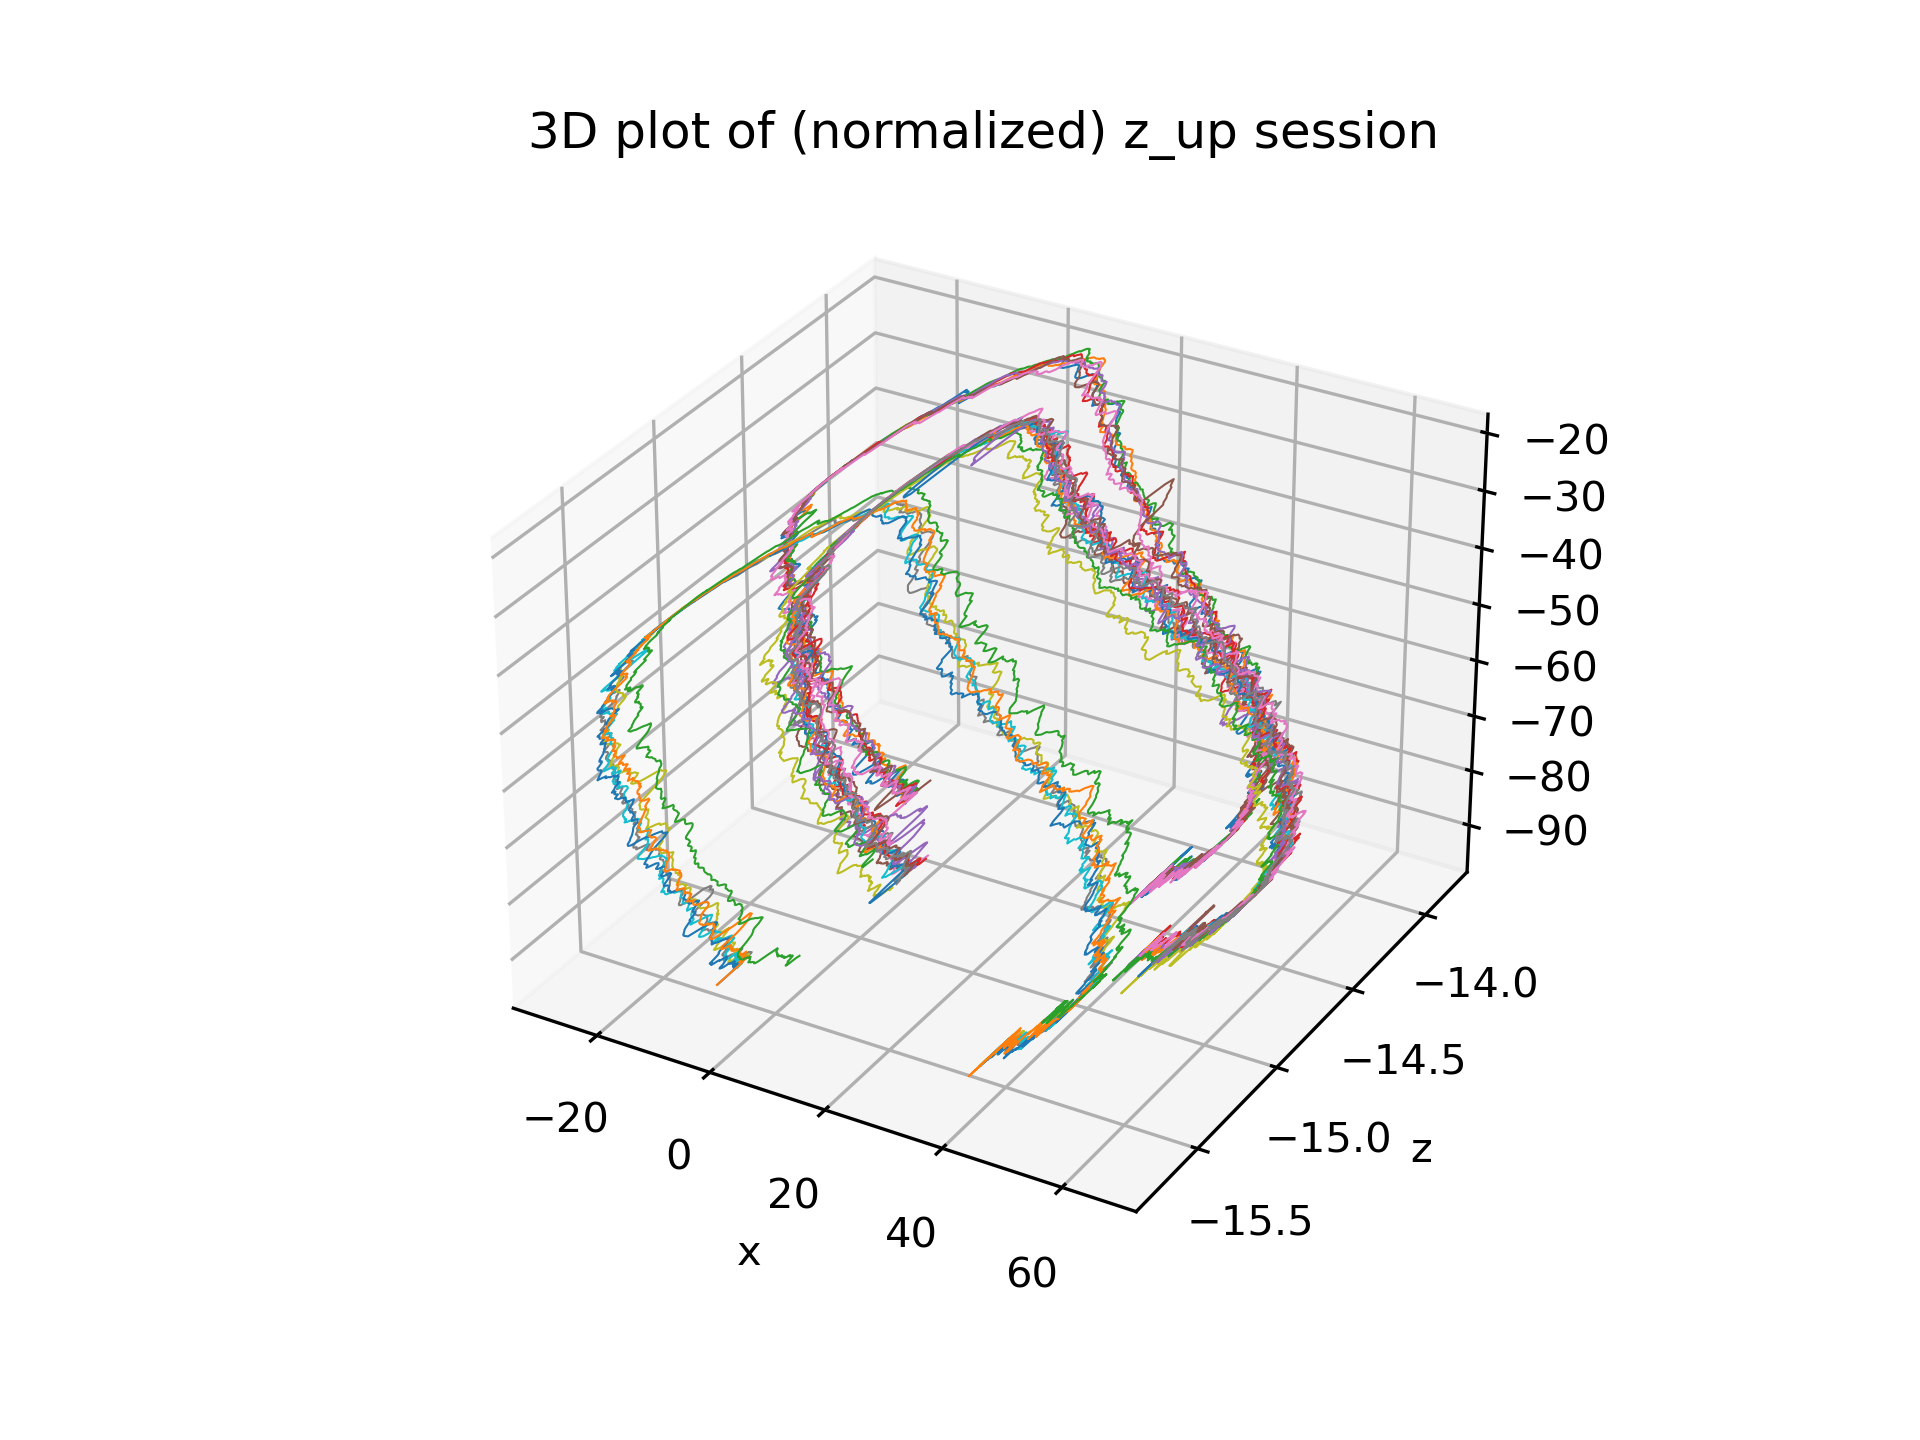

truth error too large: z_up_14
truth error too large: z_up_15
----- total of 28 cases plotted for z_up -----


<IPython.core.display.Javascript object>


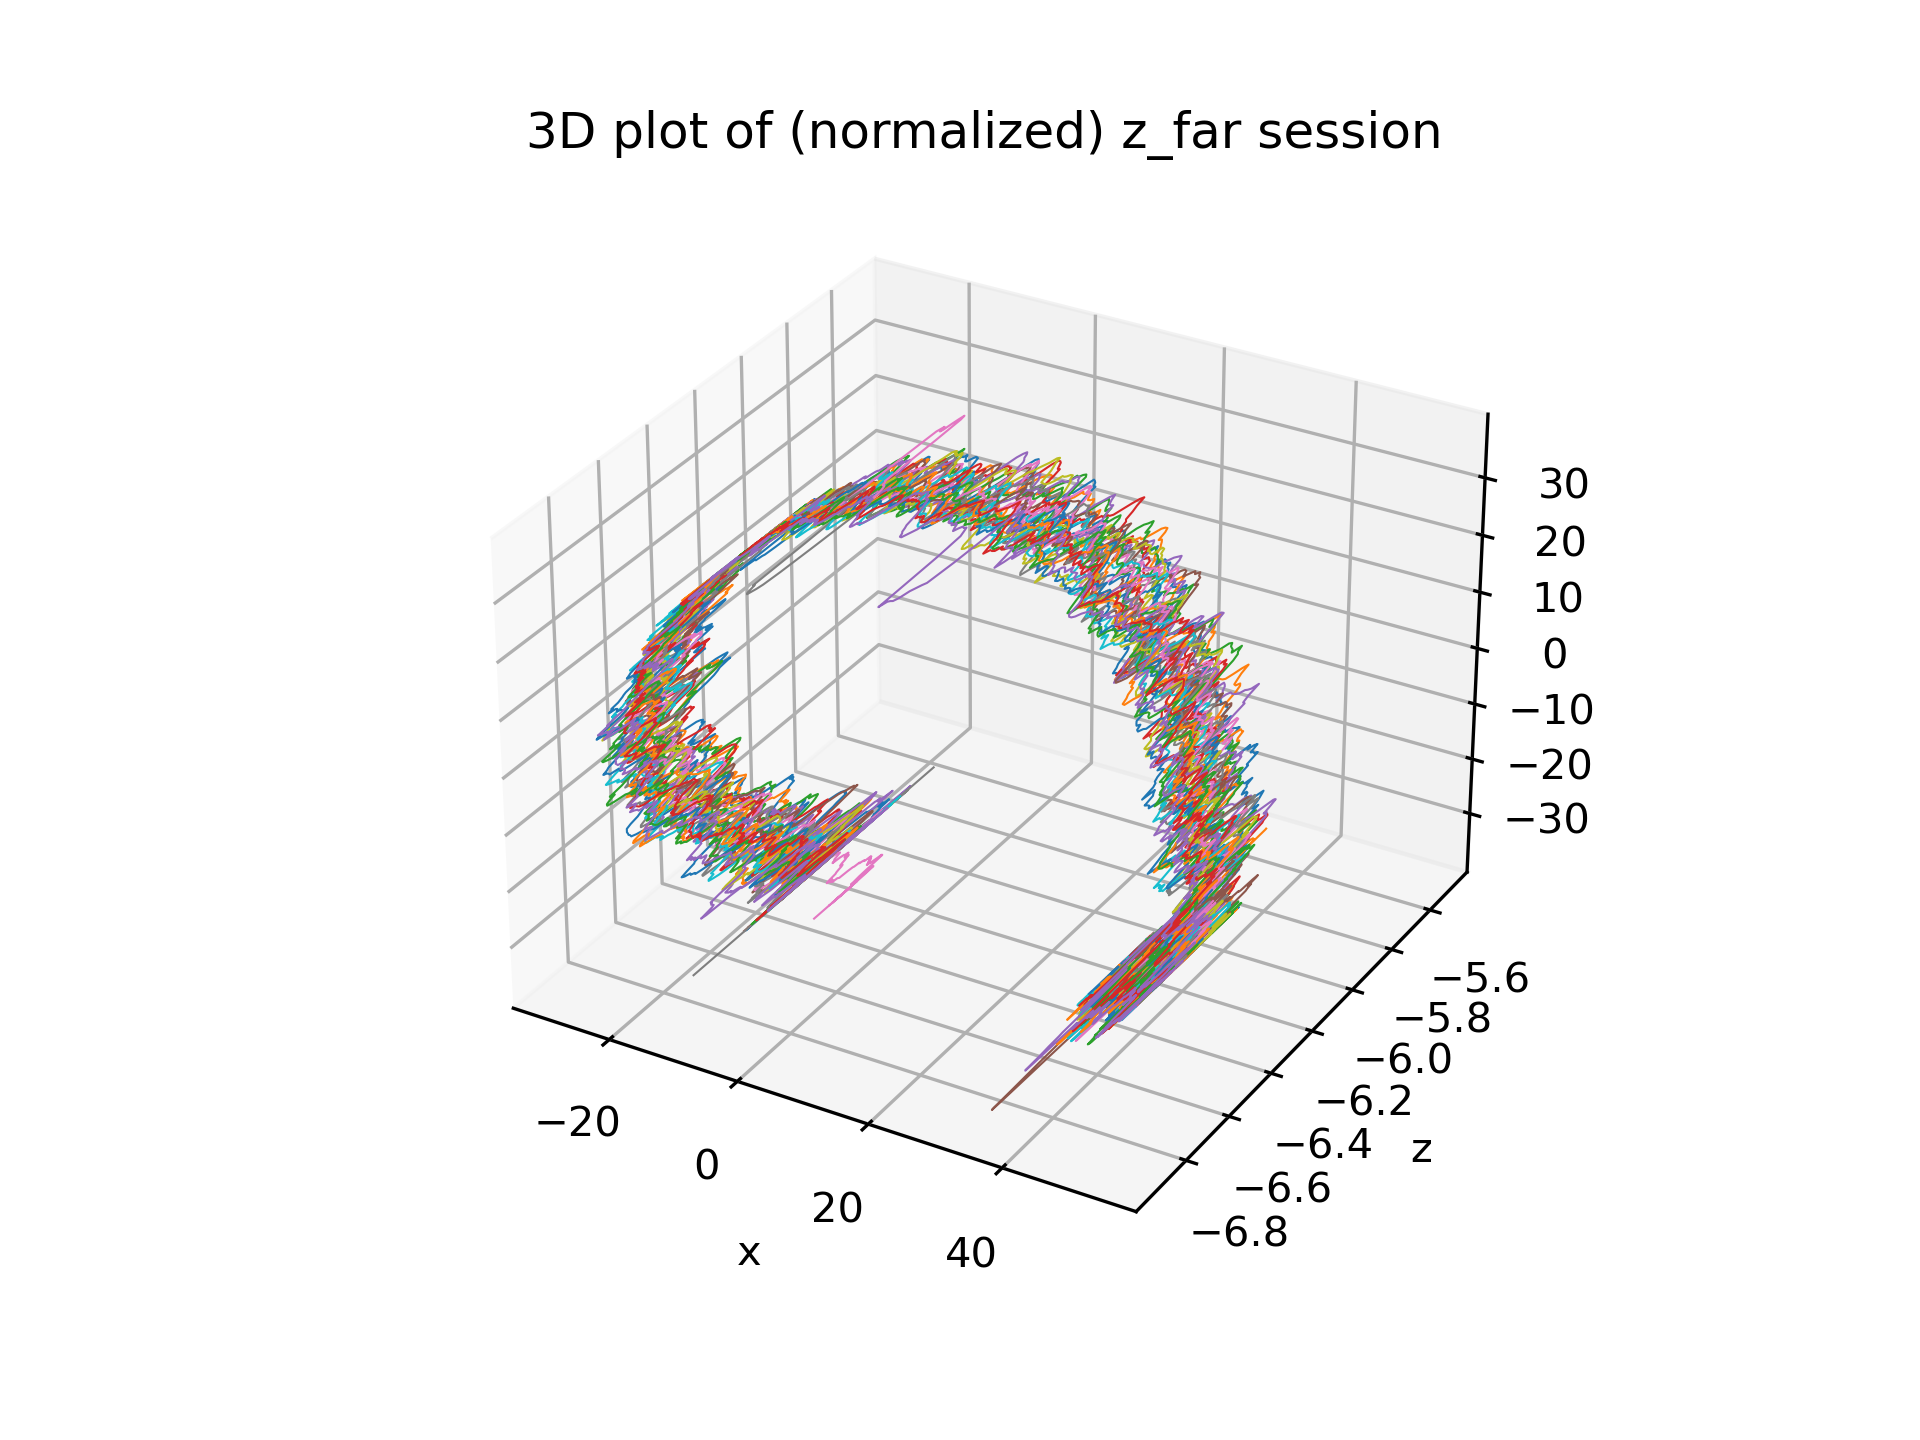

----- total of 25 cases plotted for z_far -----


<IPython.core.display.Javascript object>


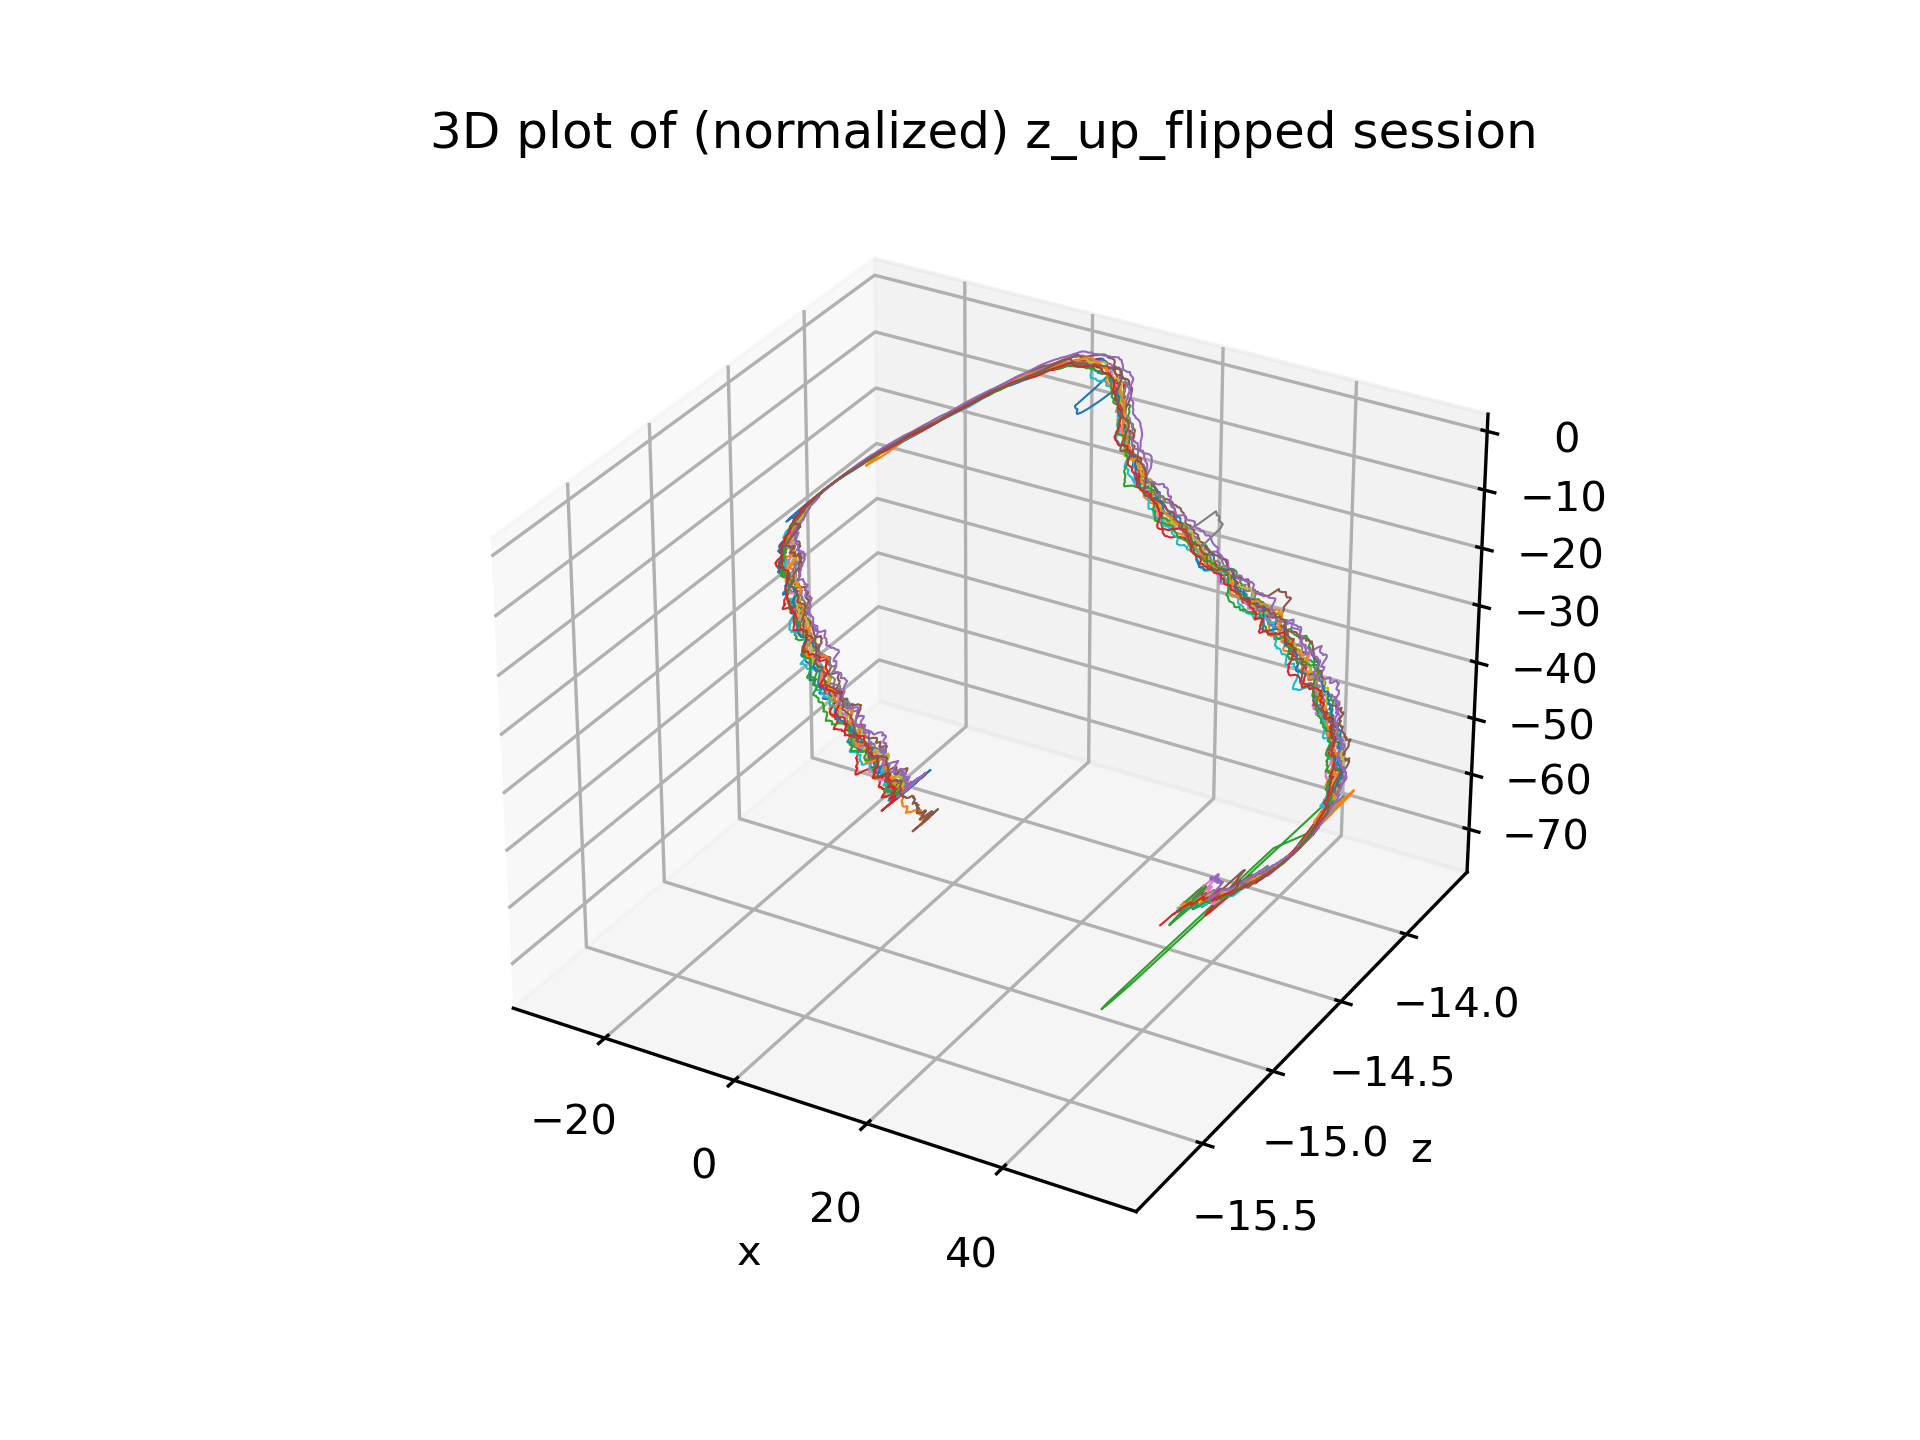

----- total of 16 cases plotted for z_up_flipped -----


<IPython.core.display.Javascript object>


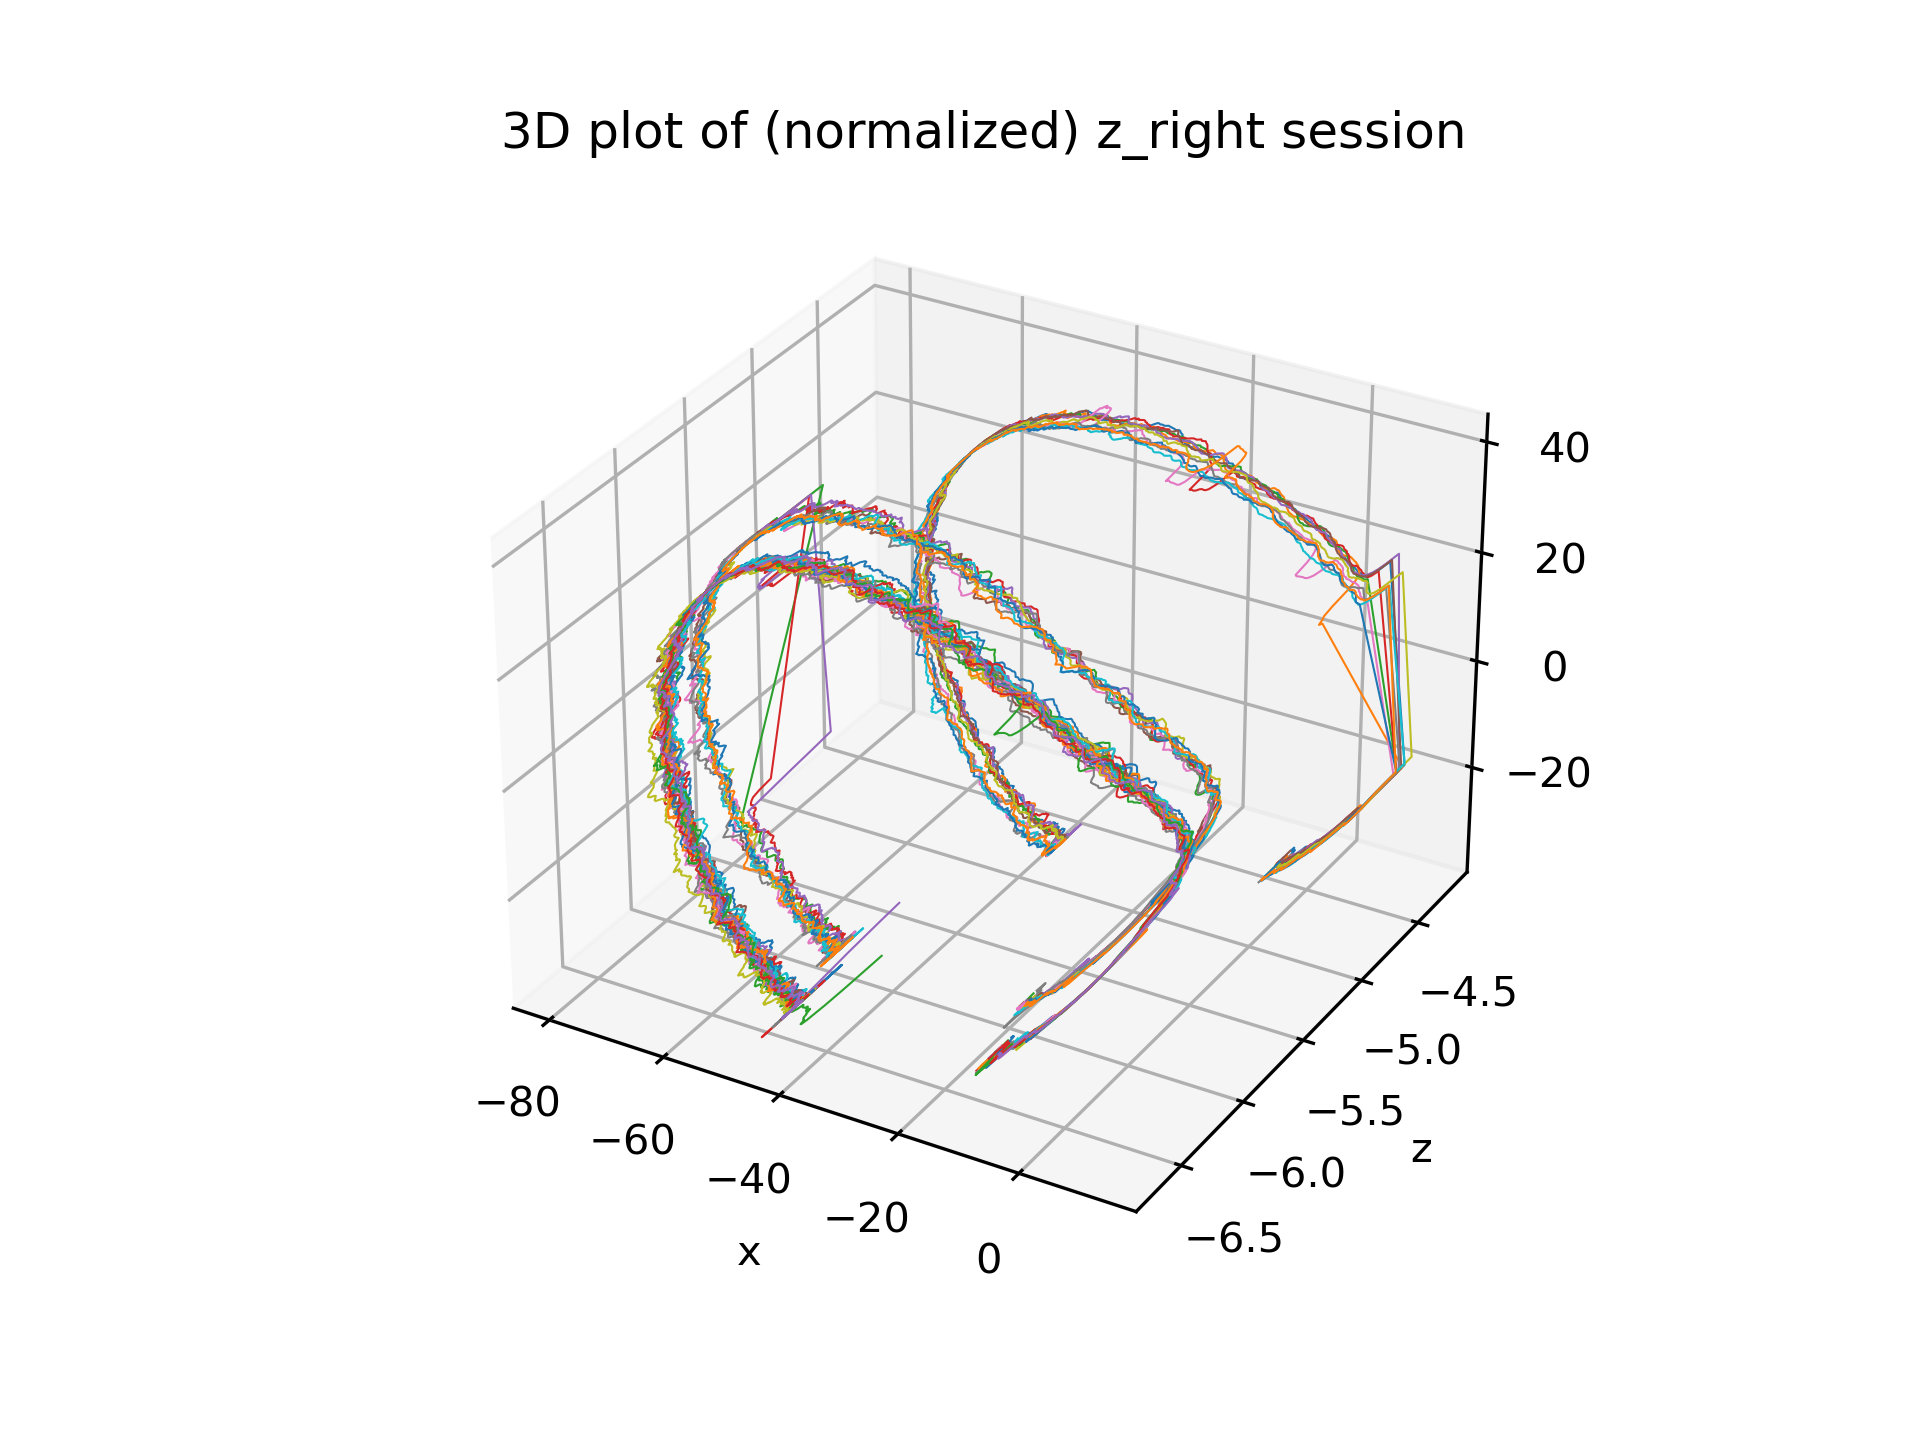

----- total of 45 cases plotted for z_right -----


<IPython.core.display.Javascript object>


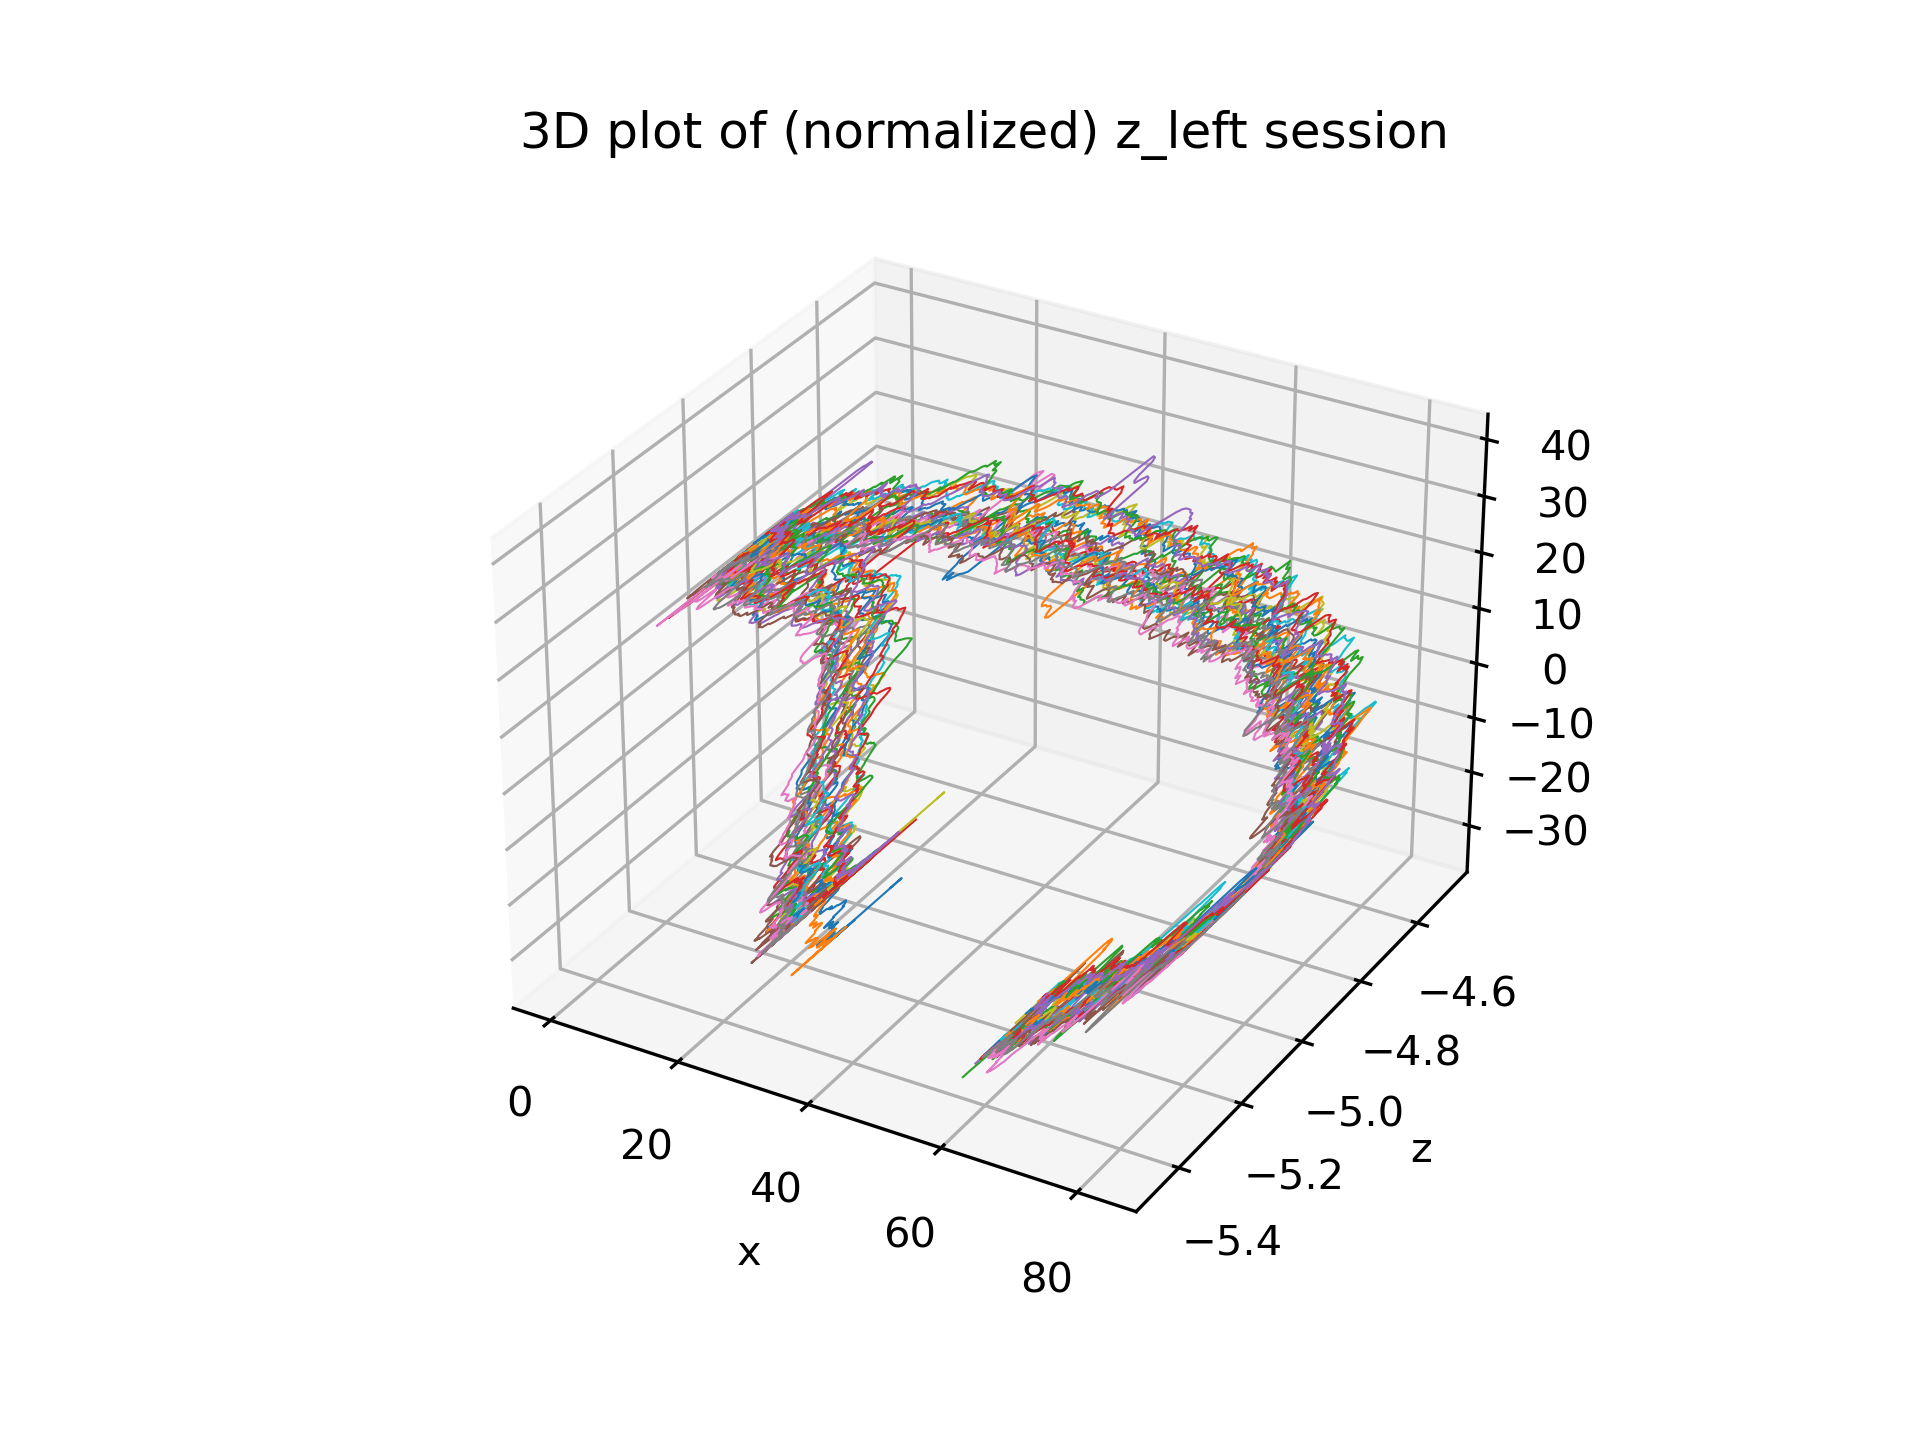

----- total of 25 cases plotted for z_left -----


<IPython.core.display.Javascript object>


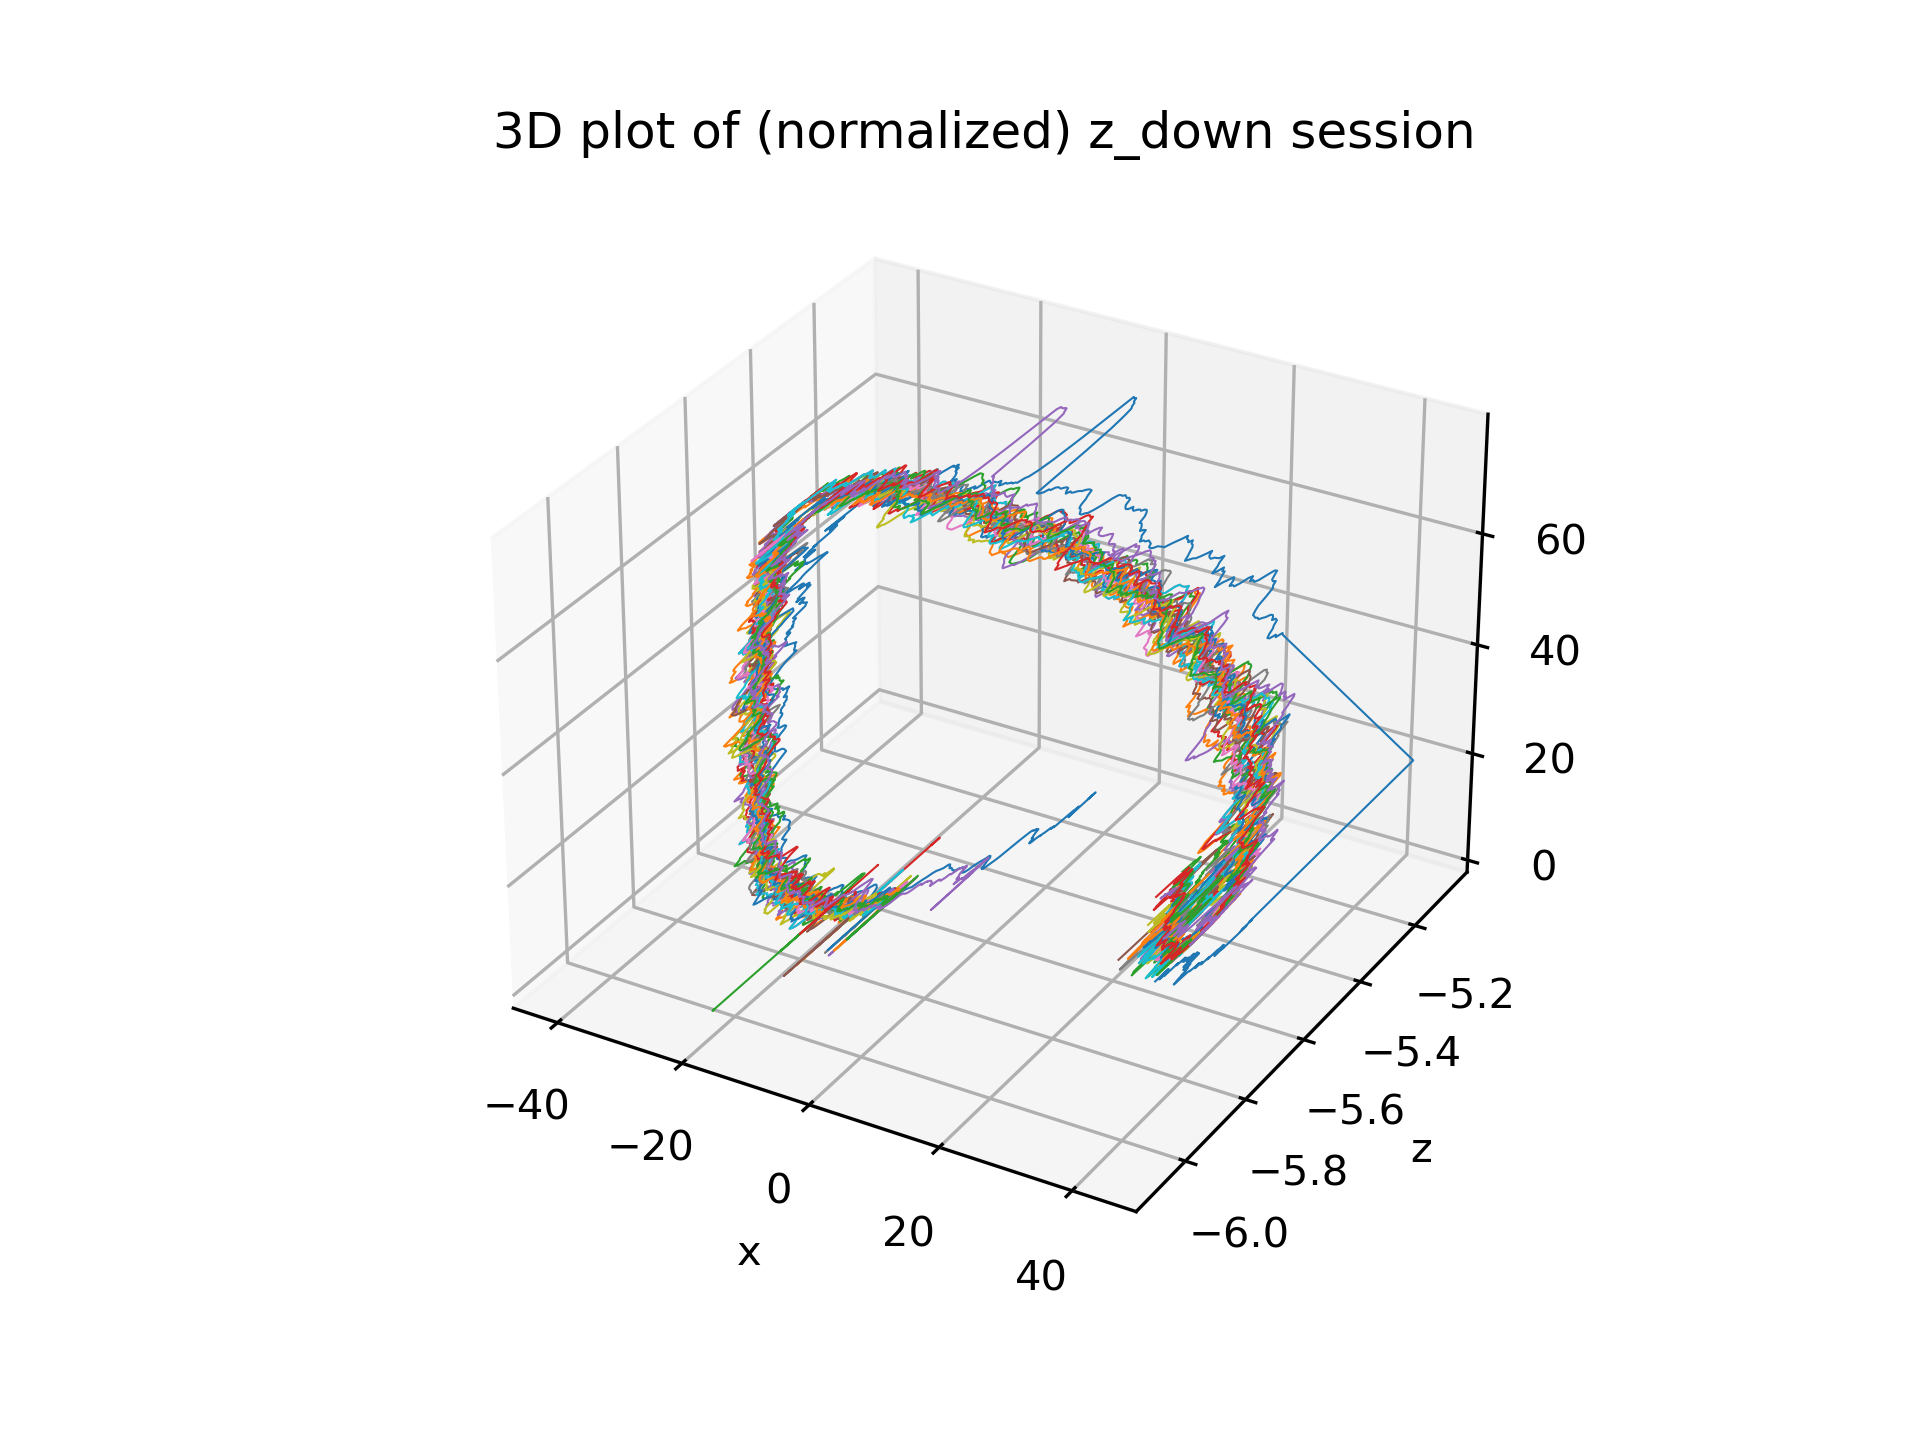

----- total of 25 cases plotted for z_down -----


<IPython.core.display.Javascript object>


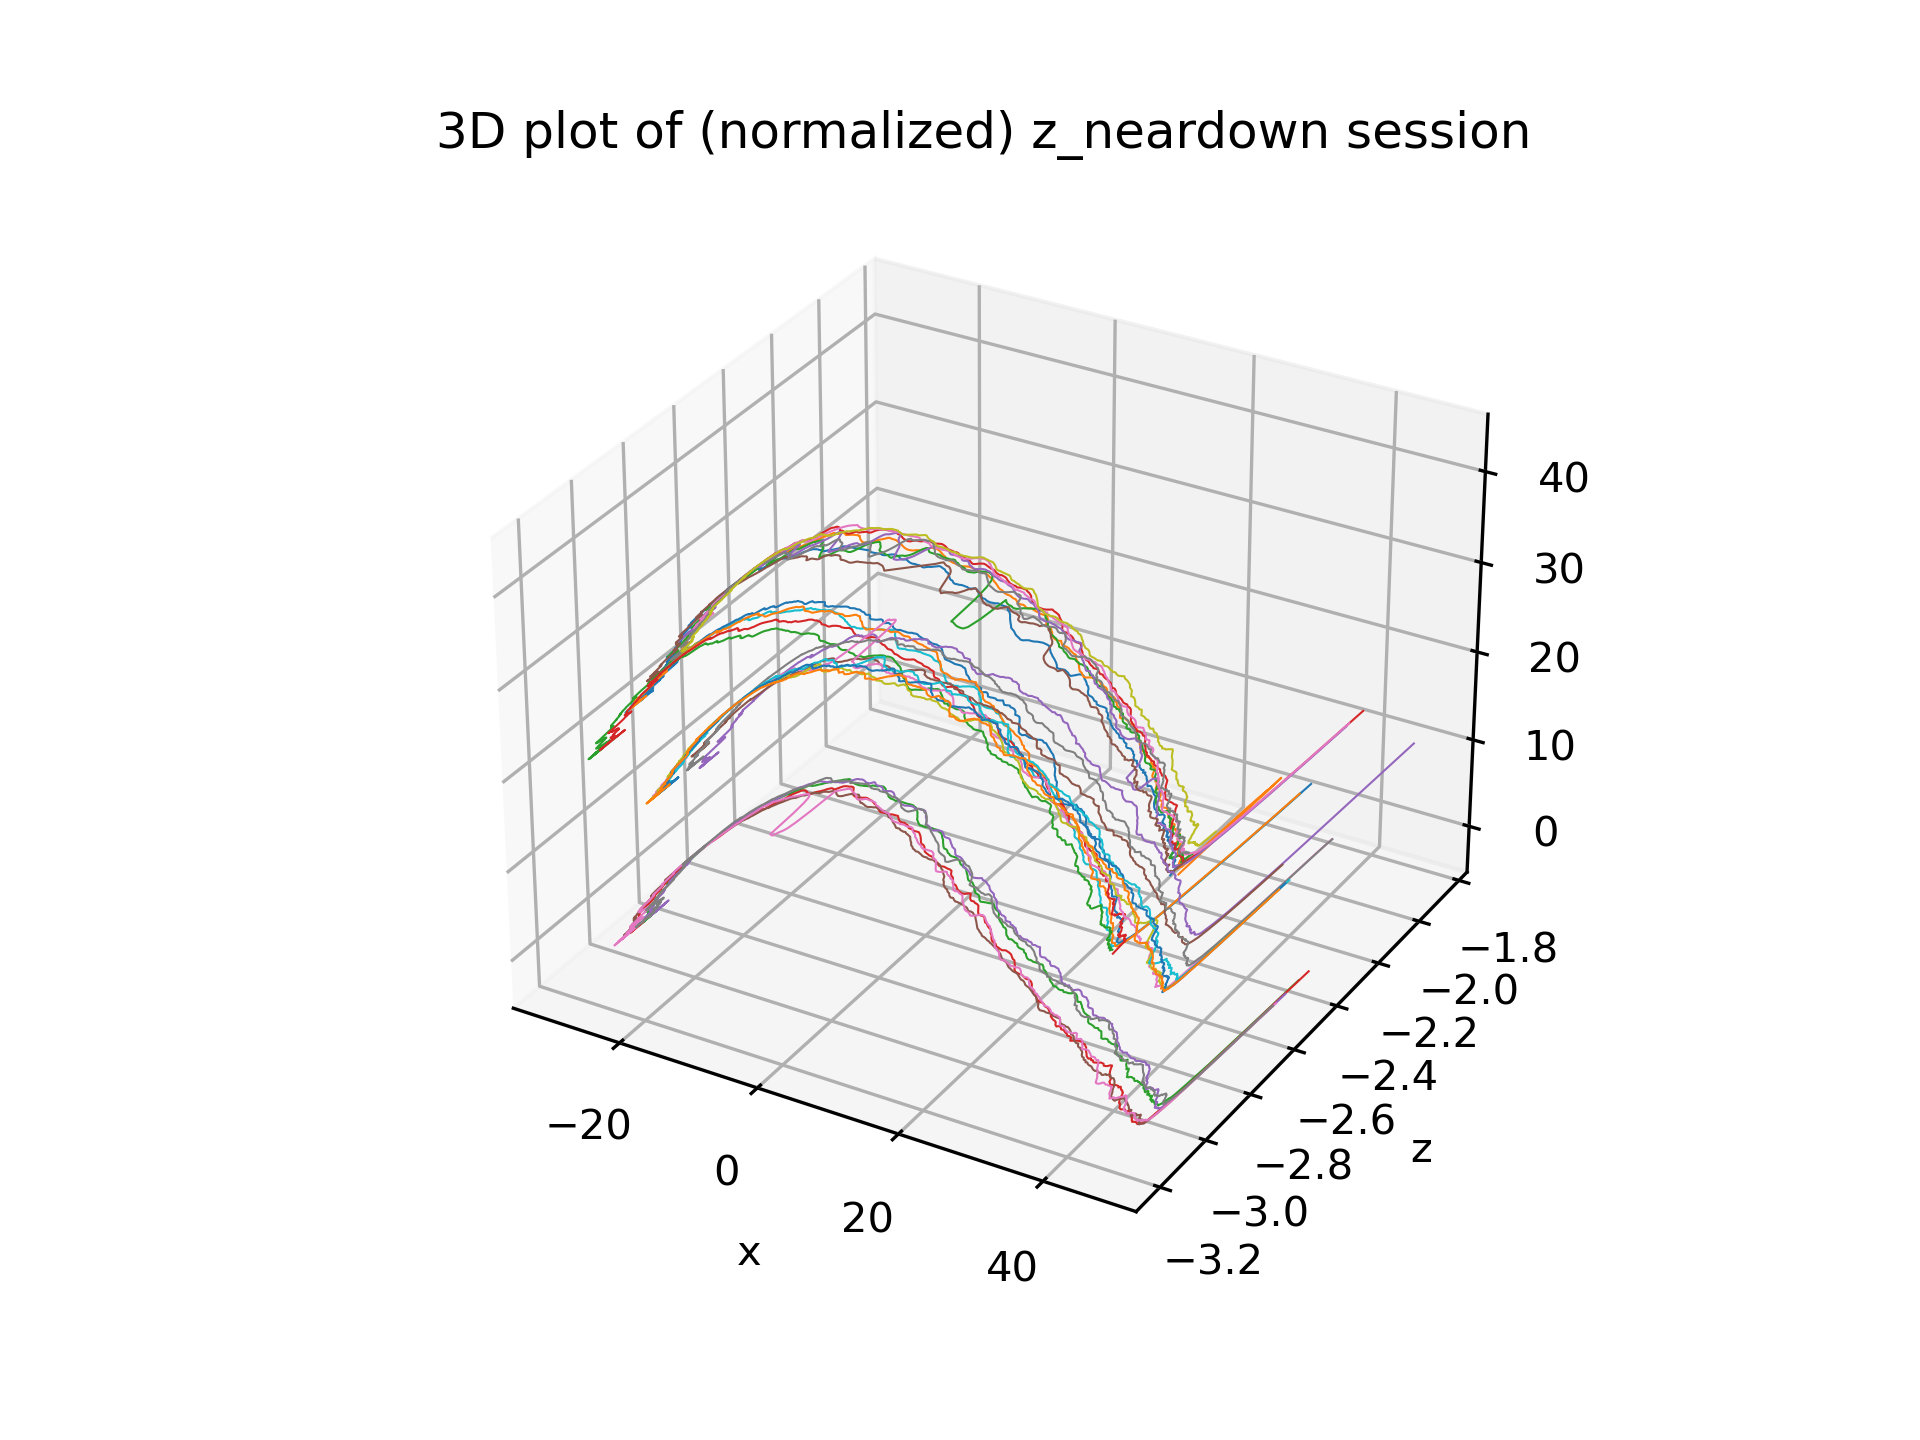

----- total of 28 cases plotted for z_neardown -----


<IPython.core.display.Javascript object>


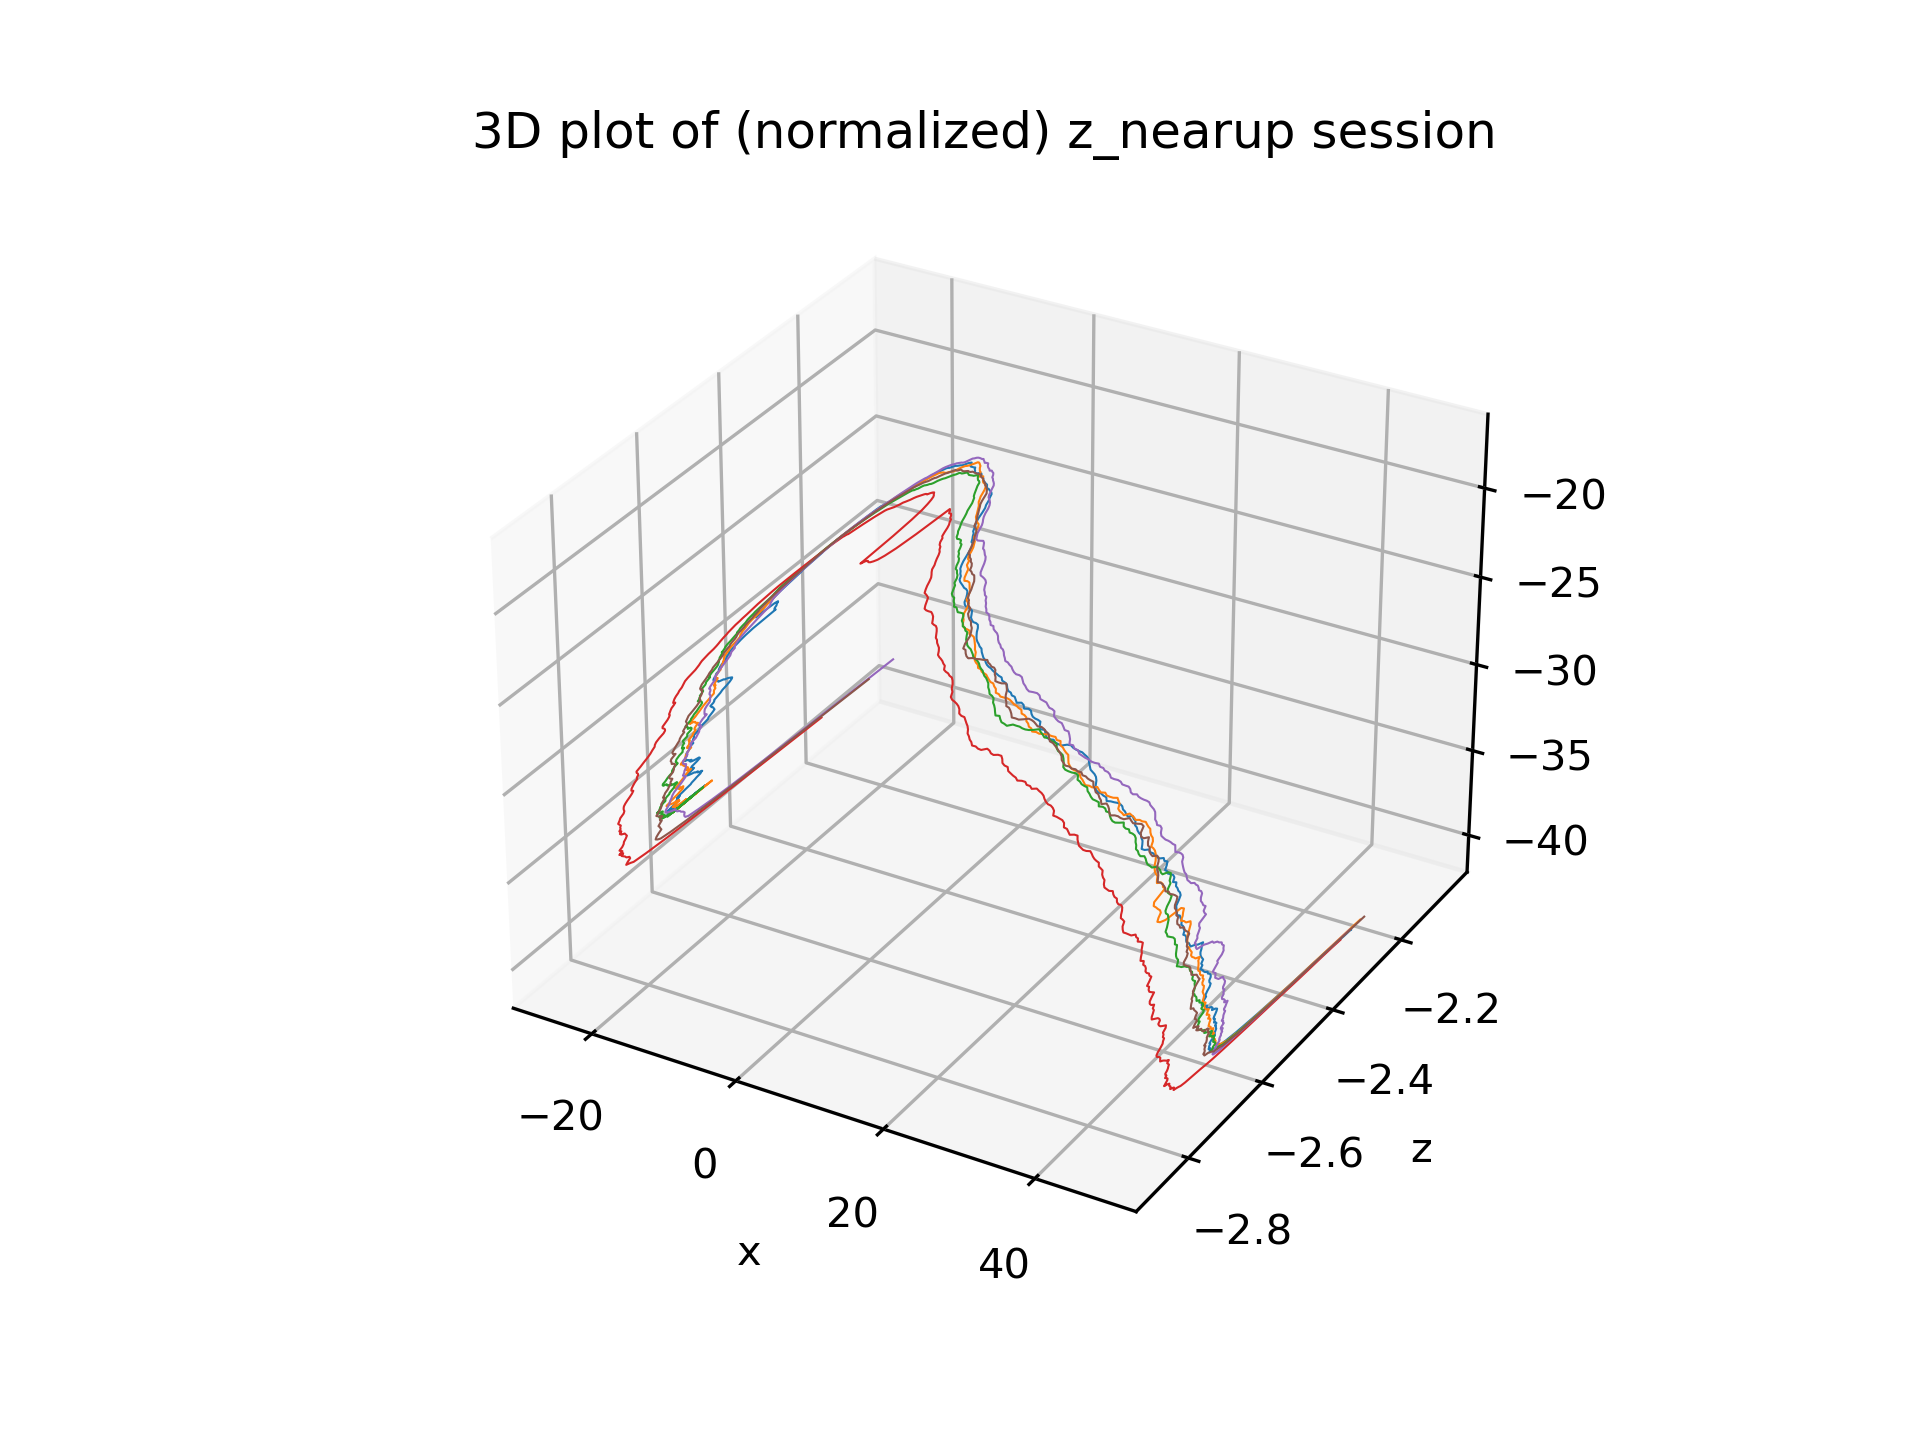

----- total of 6 cases plotted for z_nearup -----


<IPython.core.display.Javascript object>


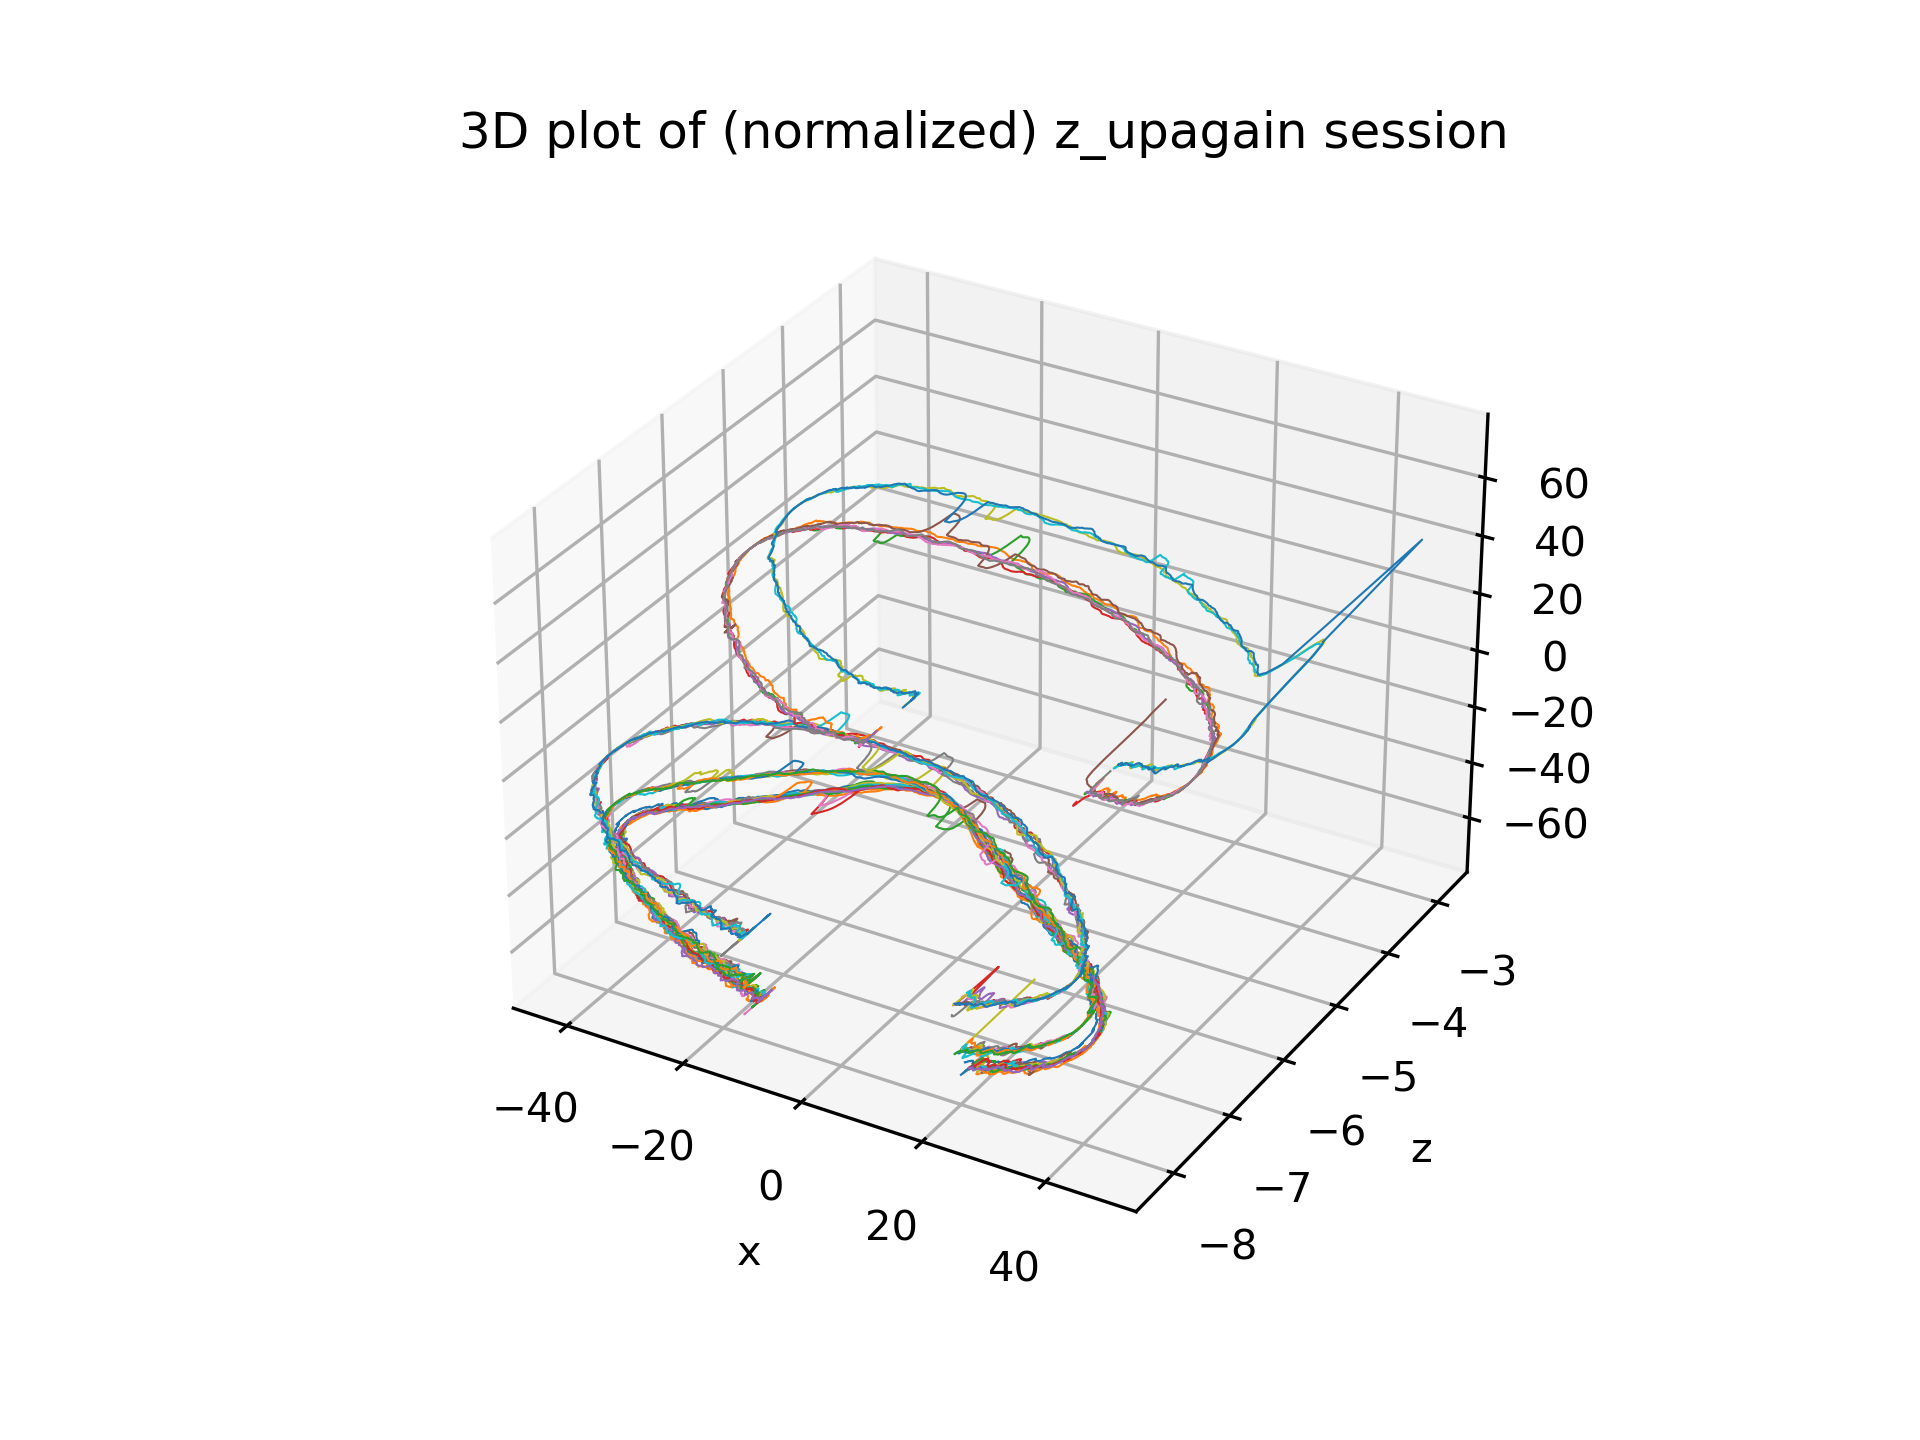

----- total of 41 cases plotted for z_upagain -----


<IPython.core.display.Javascript object>


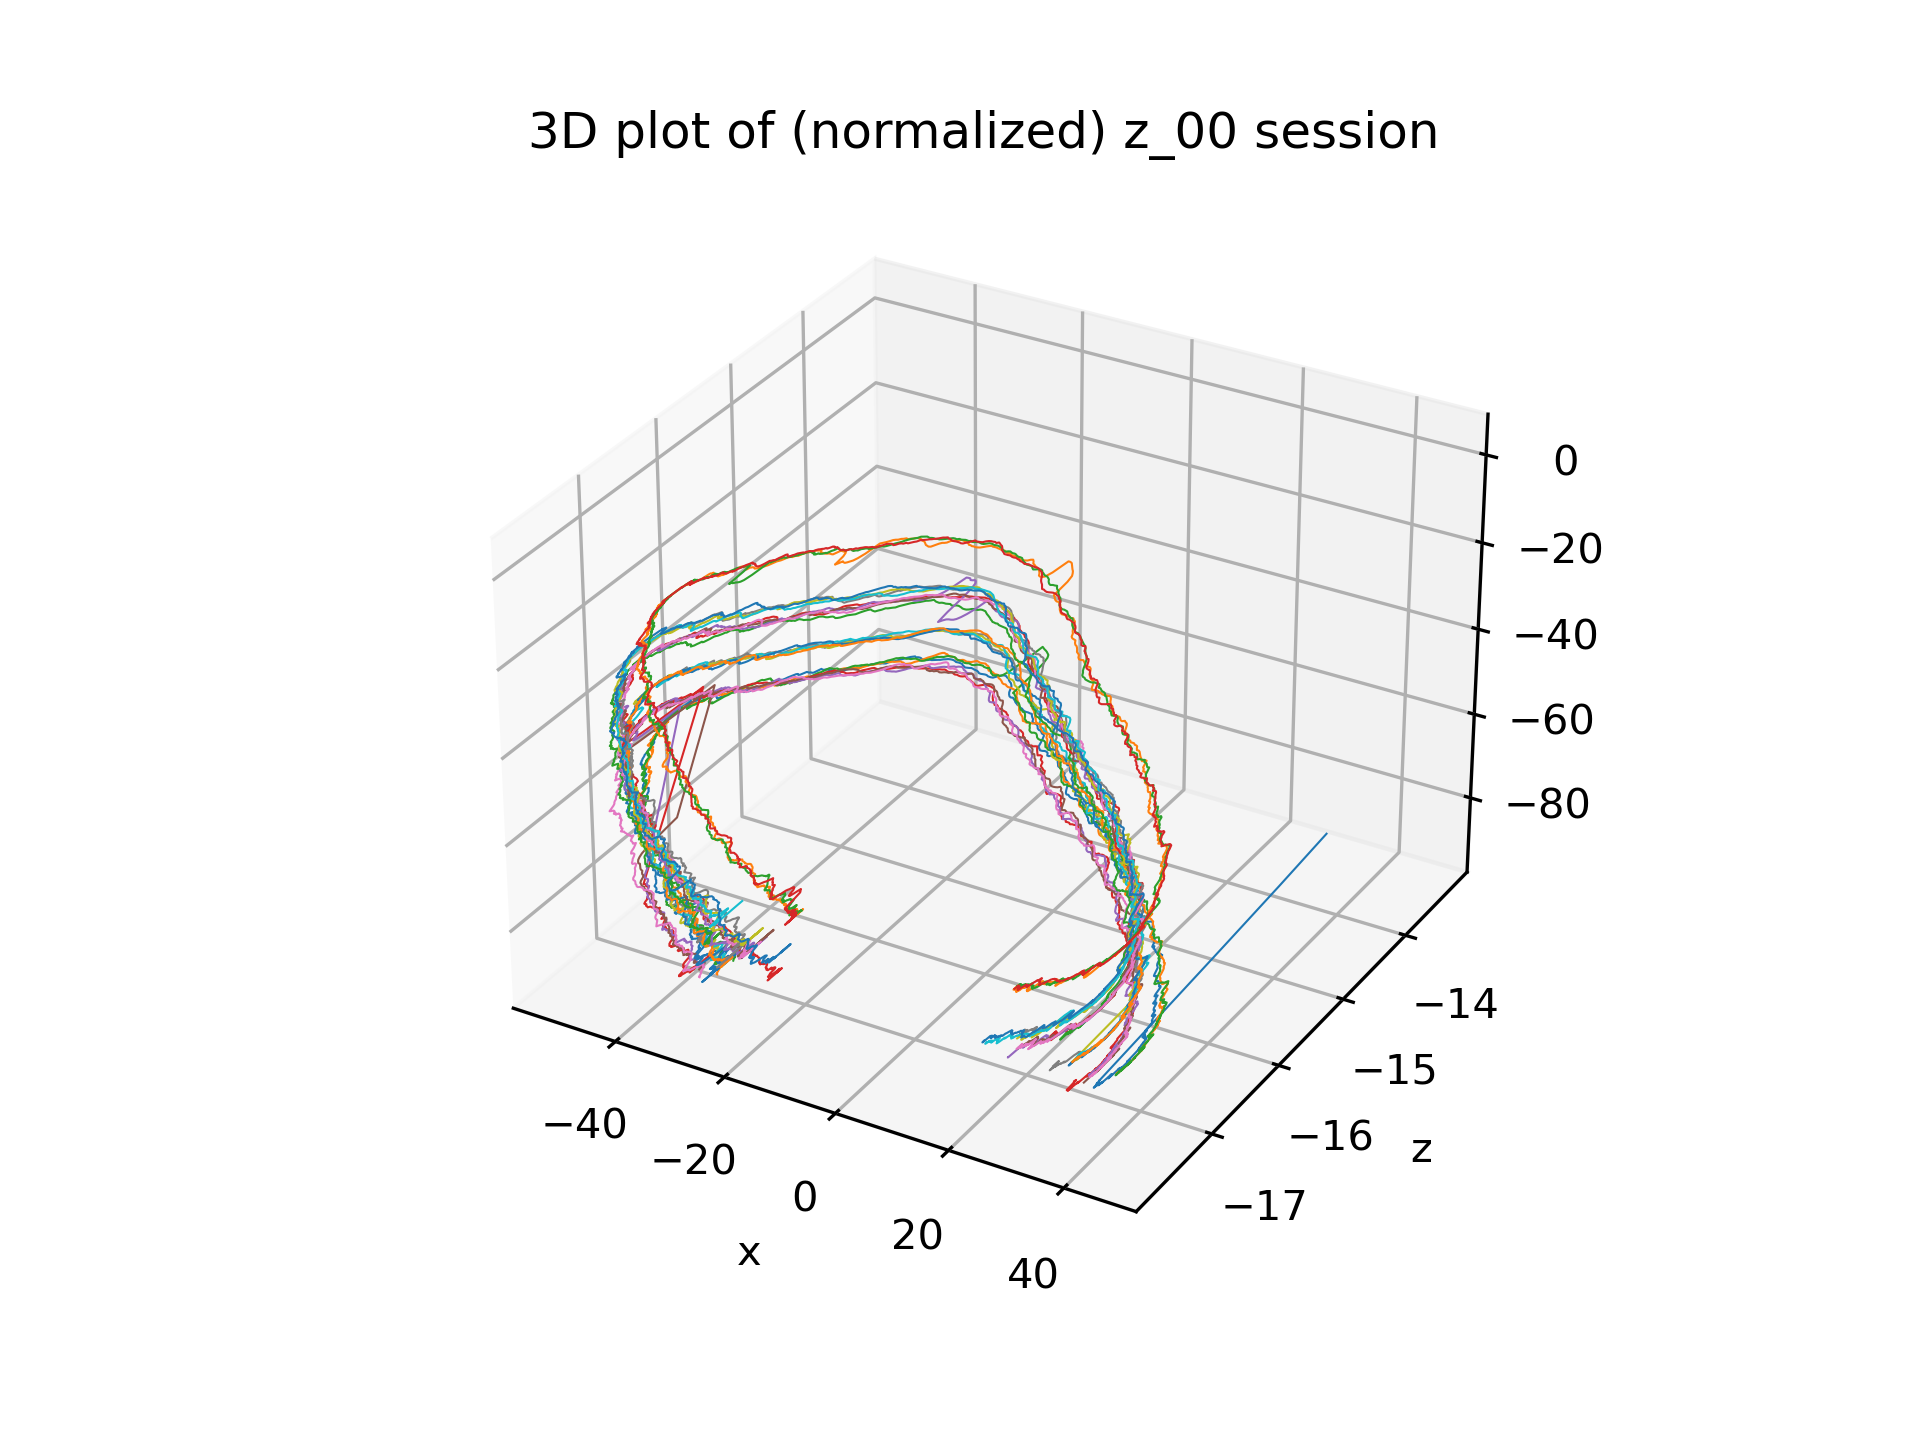

----- total of 24 cases plotted for z_00 -----


In [26]:
%matplotlib notebook
session_count = 0
# fig, axs = plt.subplots(3, 3)
# ax = plt.axes(projection='3d')
err_tracks = [] # keeps all track names that has error too large

for session in data.keys():
    session_data = data[session]
    if str(session).split("_")[0] != "z":
        break
    track_count = 0
    plt.figure(session_count)
    ax = plt.axes(projection='3d')
    for track_case in session_data:
        
        temp = session_data[track_case]
        num_id = check_track_num(temp)
        if (num_id>=3):
            print("number of tracks: ",num_id)
            print("track case is: ",track_case)
        else:
        #     print("truth error: ", temp['truth_err'].mean())
            if( temp['truth_err'].mean()<30):
                temp_normalized, weight = normalize(temp)
                ax.plot3D(temp_normalized['x_cm'], \
                          temp_normalized['z_cm'] - temp_normalized['z_measured'],\
                          temp_normalized['y_cm'], linewidth=0.5)
                track_count += 1
            else:
                err_tracks.append(str(track_case))
                print("truth error too large: " + track_case)
    session_count+=1
    print("----- total of", str(track_count), "cases plotted for", session,  "-----")

    plt.xlabel("x")
    plt.ylabel("z")
    plt.title("3D plot of (normalized) " +  str(session) + " session")



#### plot single track

In [13]:
def plot_single_track(track_name, data):
    '''
    given the track name, plot the track
    and the data file of all the data
    '''
    session,_ = track_name_to_session(track_name)
    print(session, track_name)
    temp = data[session][track_name]
    temp_normalized, weight = normalize(temp)
    plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot3D(temp_normalized['x_cm'], \
      temp_normalized['z_cm'],\
      temp_normalized['y_cm'], linewidth=0.5)

    

z_neardown z_neardown_34


<IPython.core.display.Javascript object>


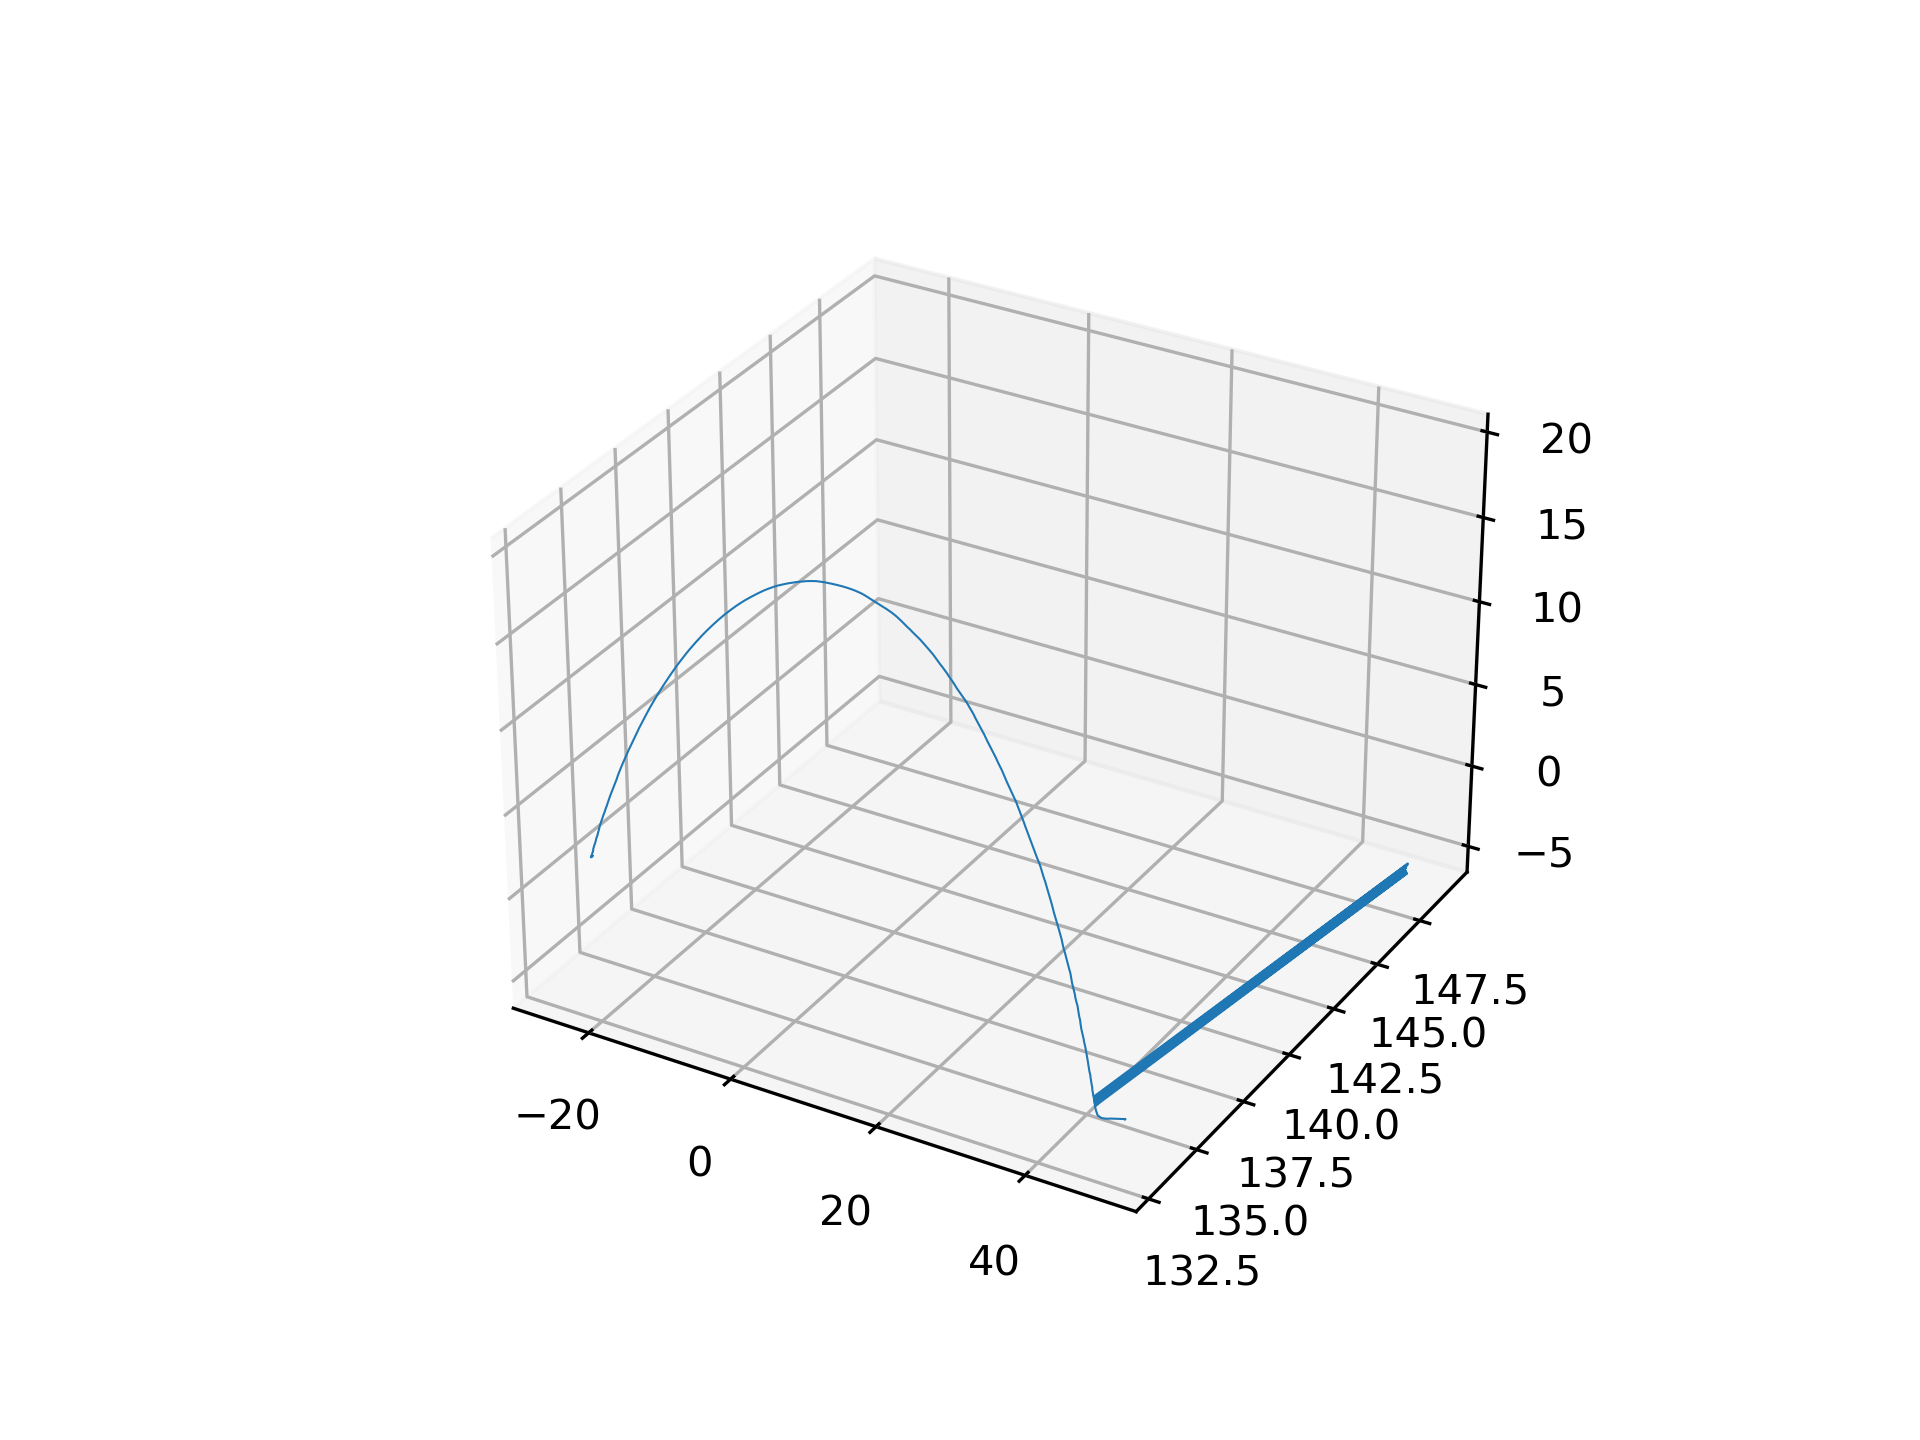

In [16]:
plot_single_track("z_neardown_34", data)

x_right x_right_1


<IPython.core.display.Javascript object>


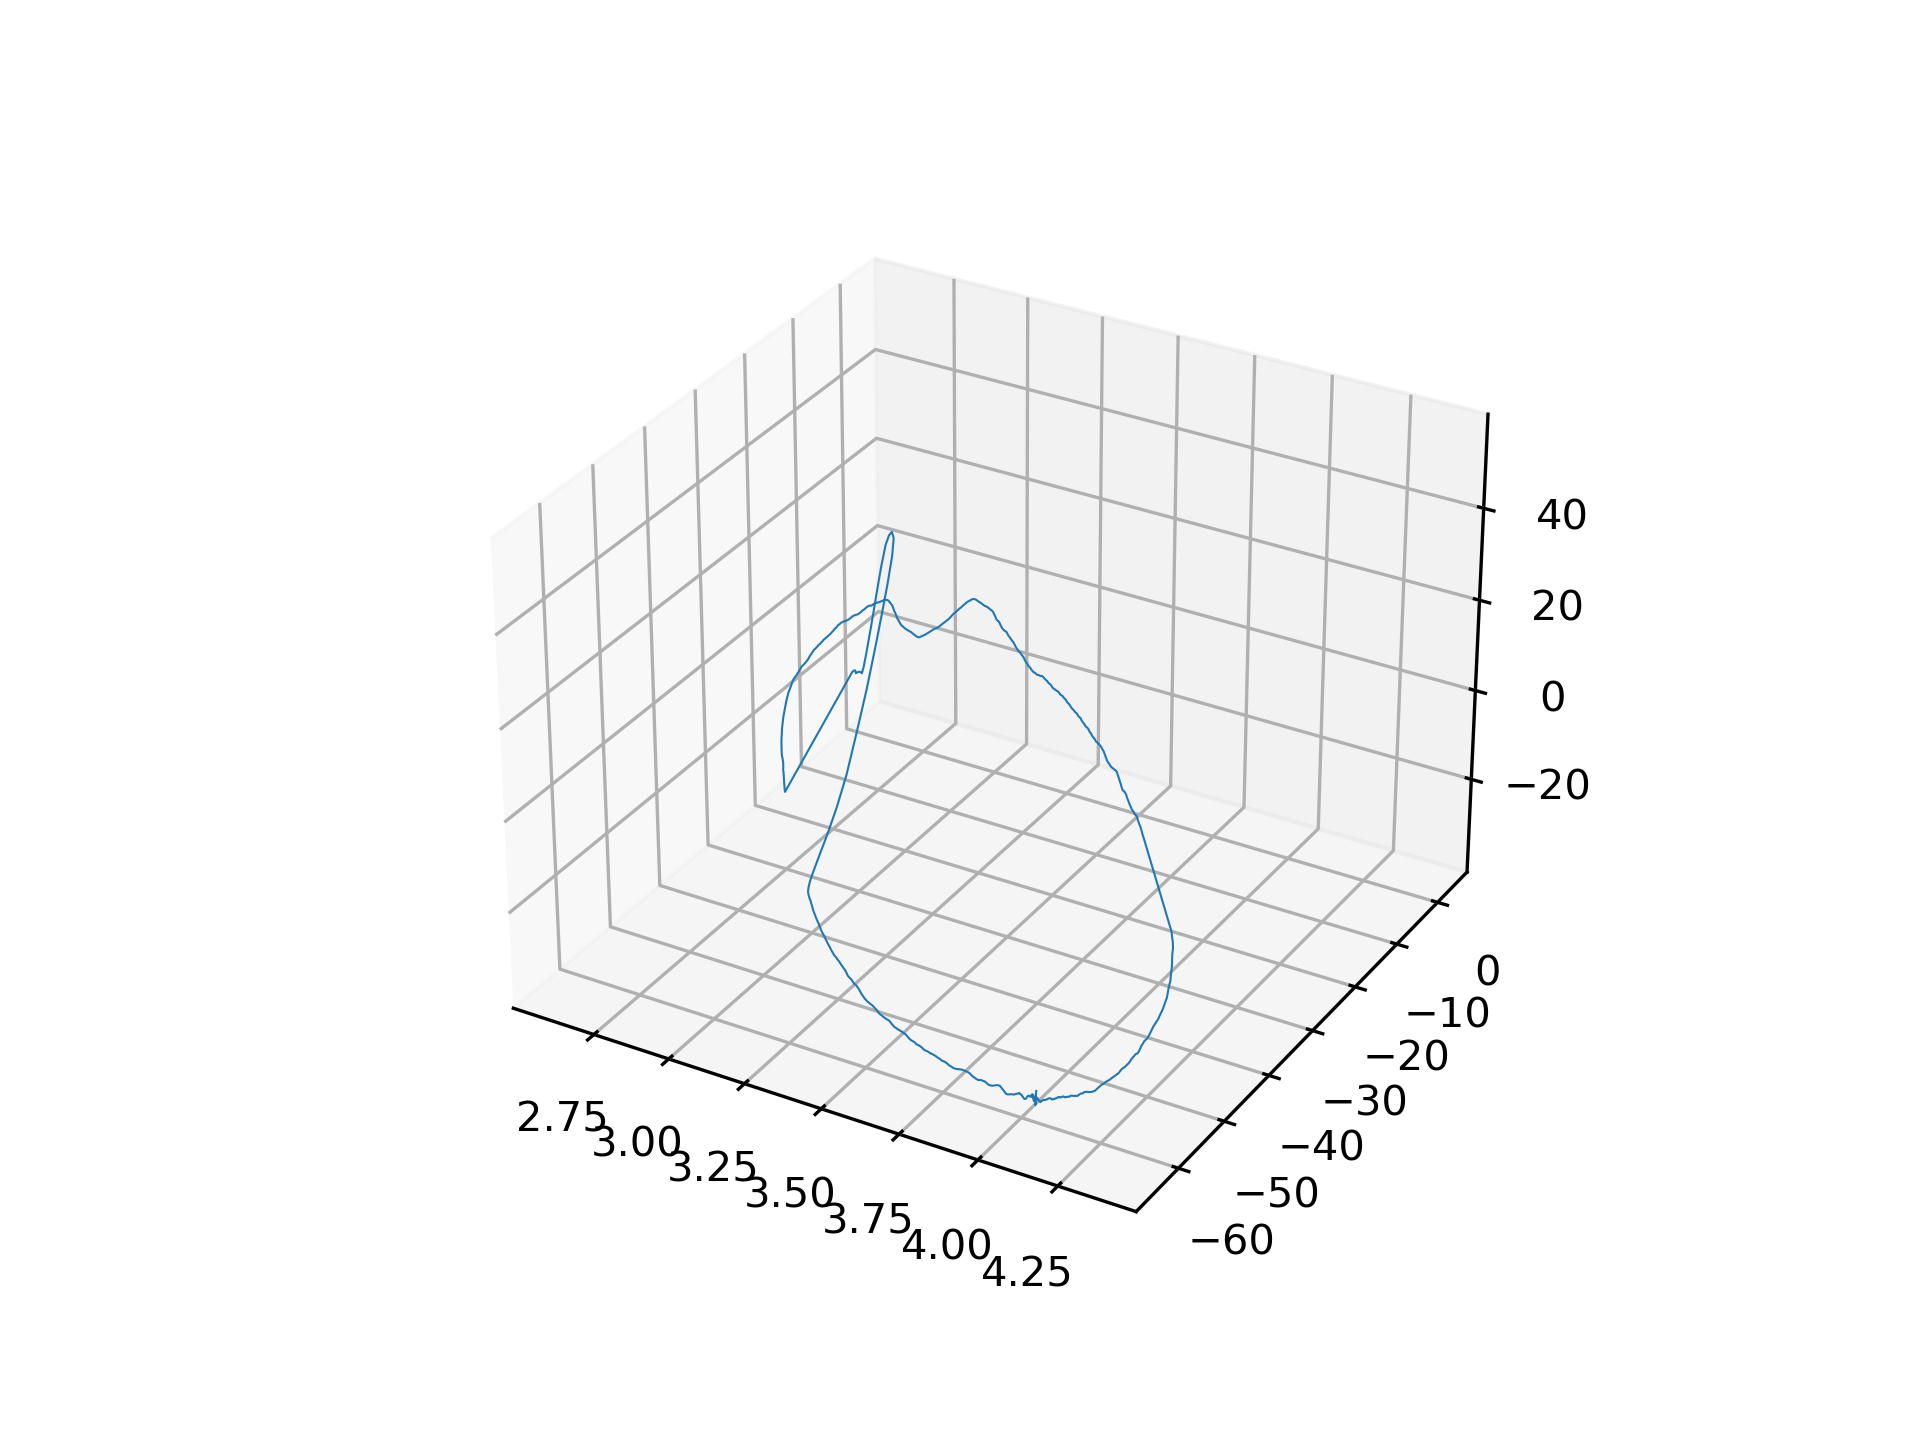

In [64]:
plot_single_track("x_right_1", data)

<IPython.core.display.Javascript object>


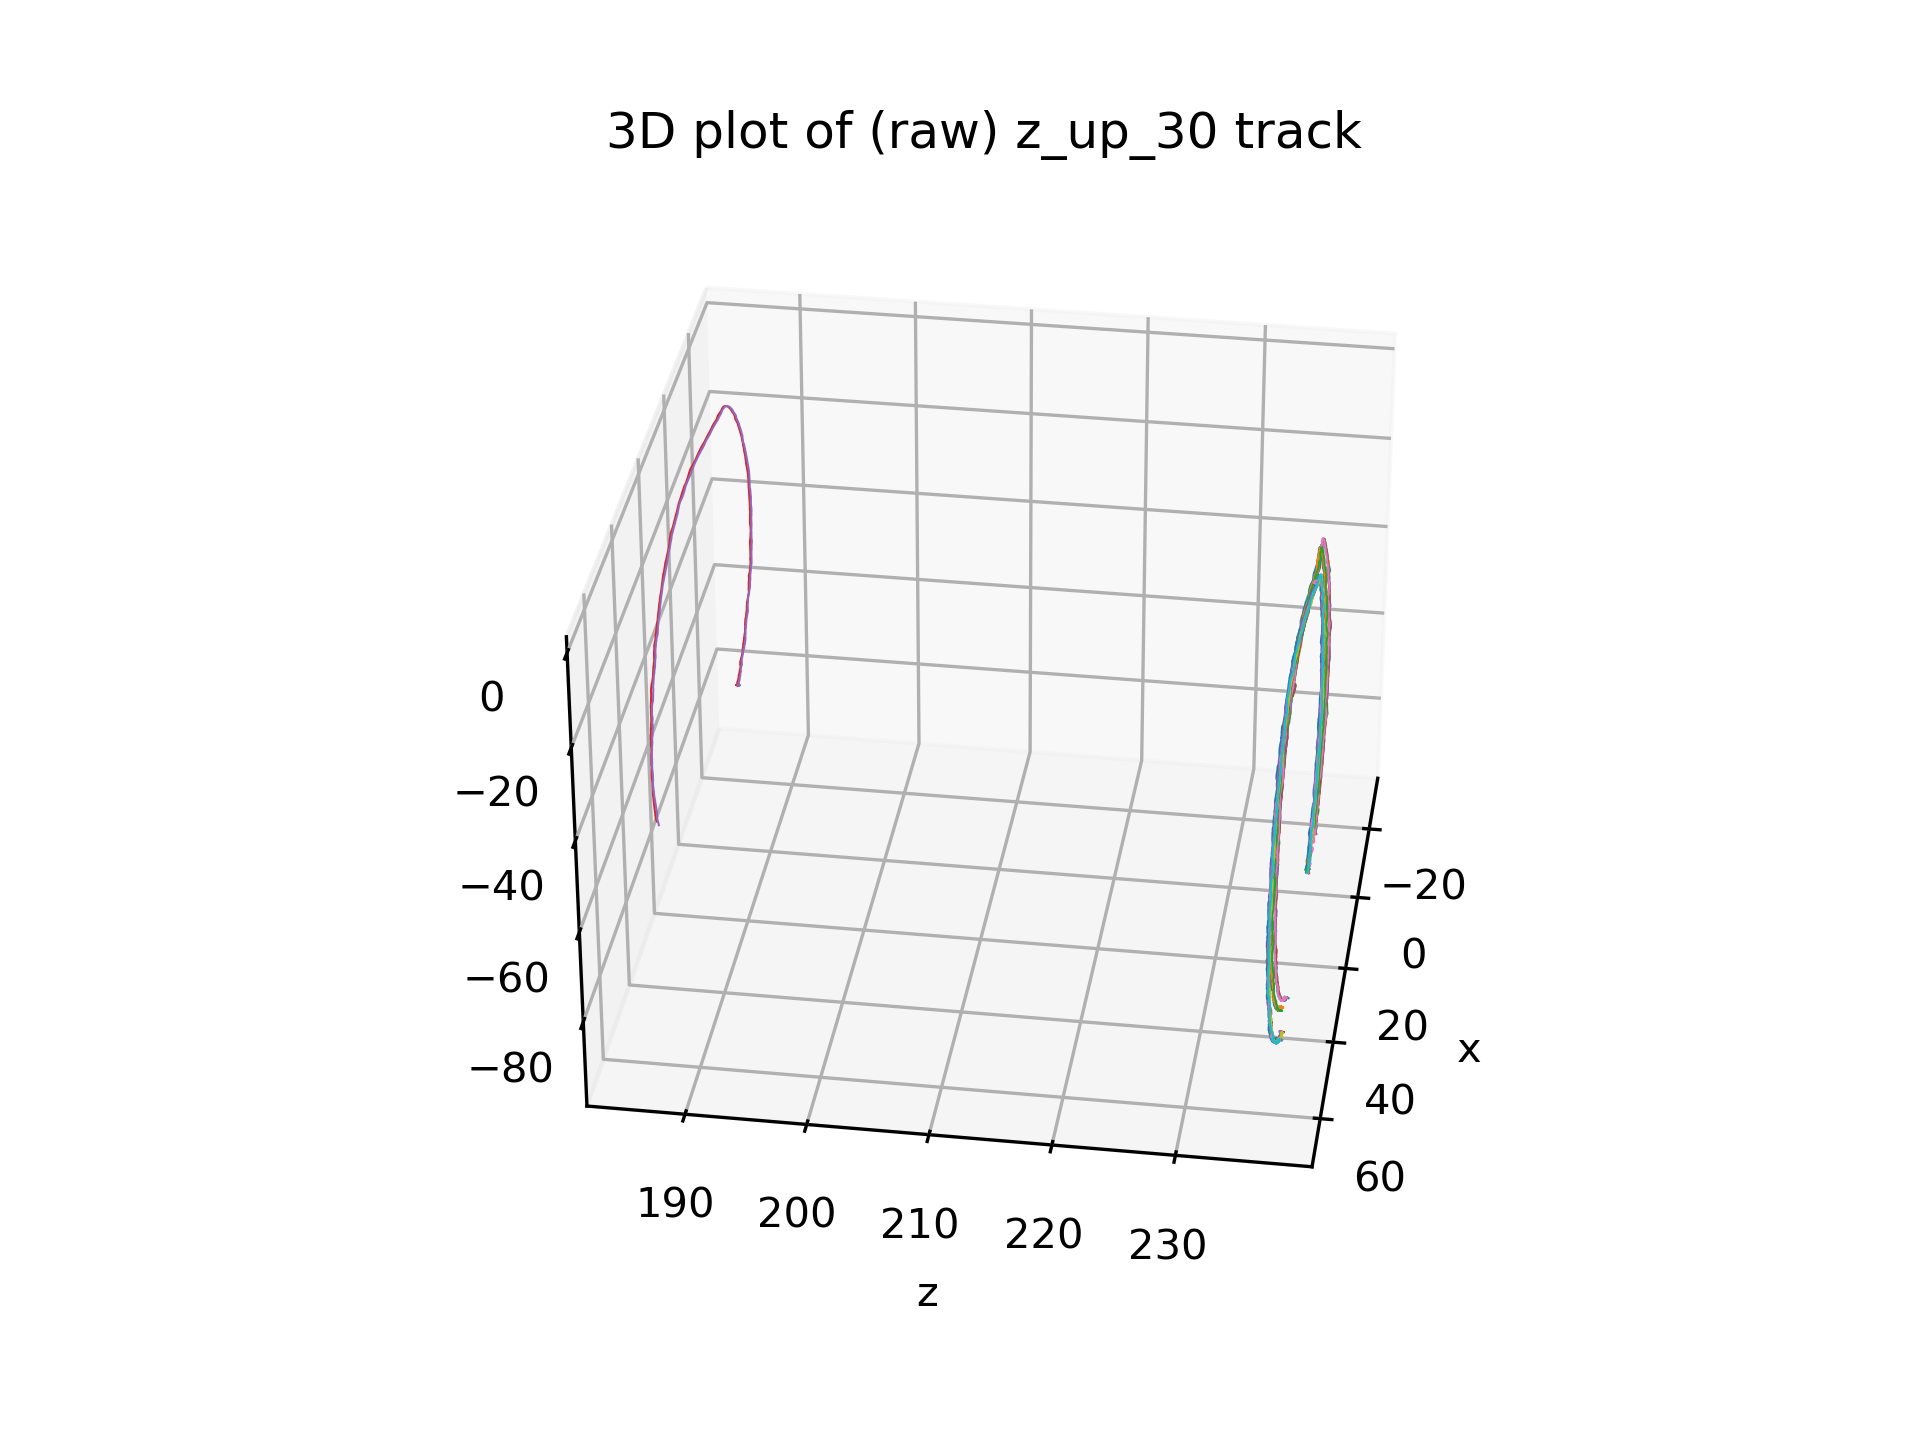

Text(0.5, 0.92, '3D plot of (raw) z_up_30 track')

In [29]:
%matplotlib notebook
plt.figure()
ax = plt.axes(projection='3d')
session = "z_up"
session_data = data[session]
for track_case in session_data.keys():
    

    temp = session_data[track_case]
    temp_normalized, weight = normalize(temp)

    ax.plot3D(temp_normalized['x_cm'], \
          temp_normalized['z_cm'],\
          temp_normalized['y_cm'], linewidth=0.5)




    

# plt.legend()
plt.xlabel("x")
plt.ylabel("z")
plt.title("3D plot of (raw) " +  str(track_case) + " track")
# plt.ylim(200, 202)
# plt.zlabel("z")
# plt.ioff()


In [71]:
x_keys = ["x_center", "x_right"]

<IPython.core.display.Javascript object>


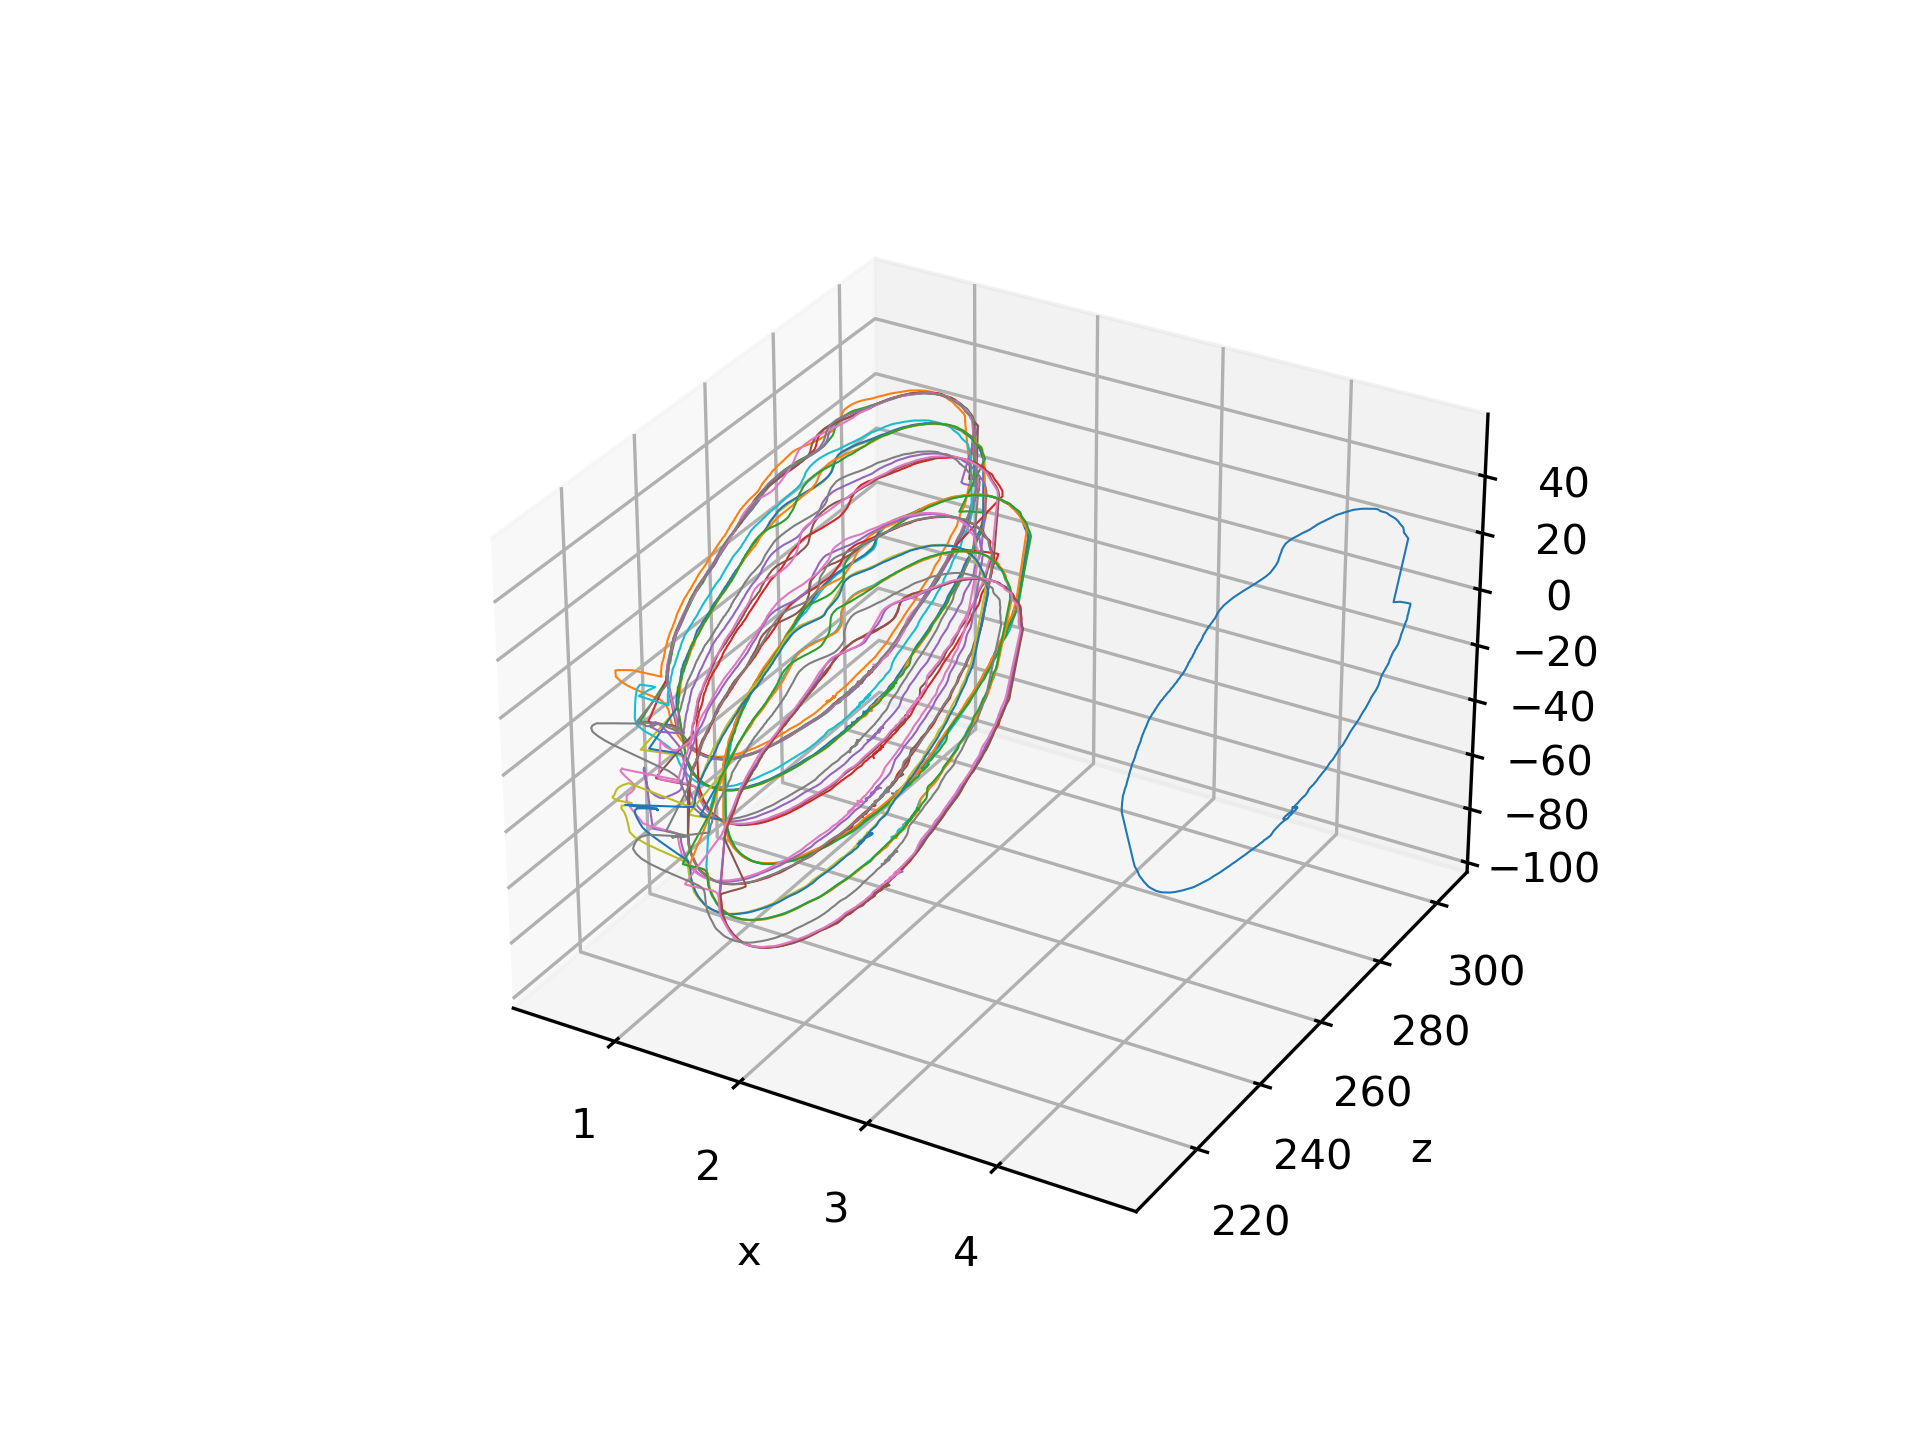

----- total of 38 cases plotted for x_center -----


<IPython.core.display.Javascript object>


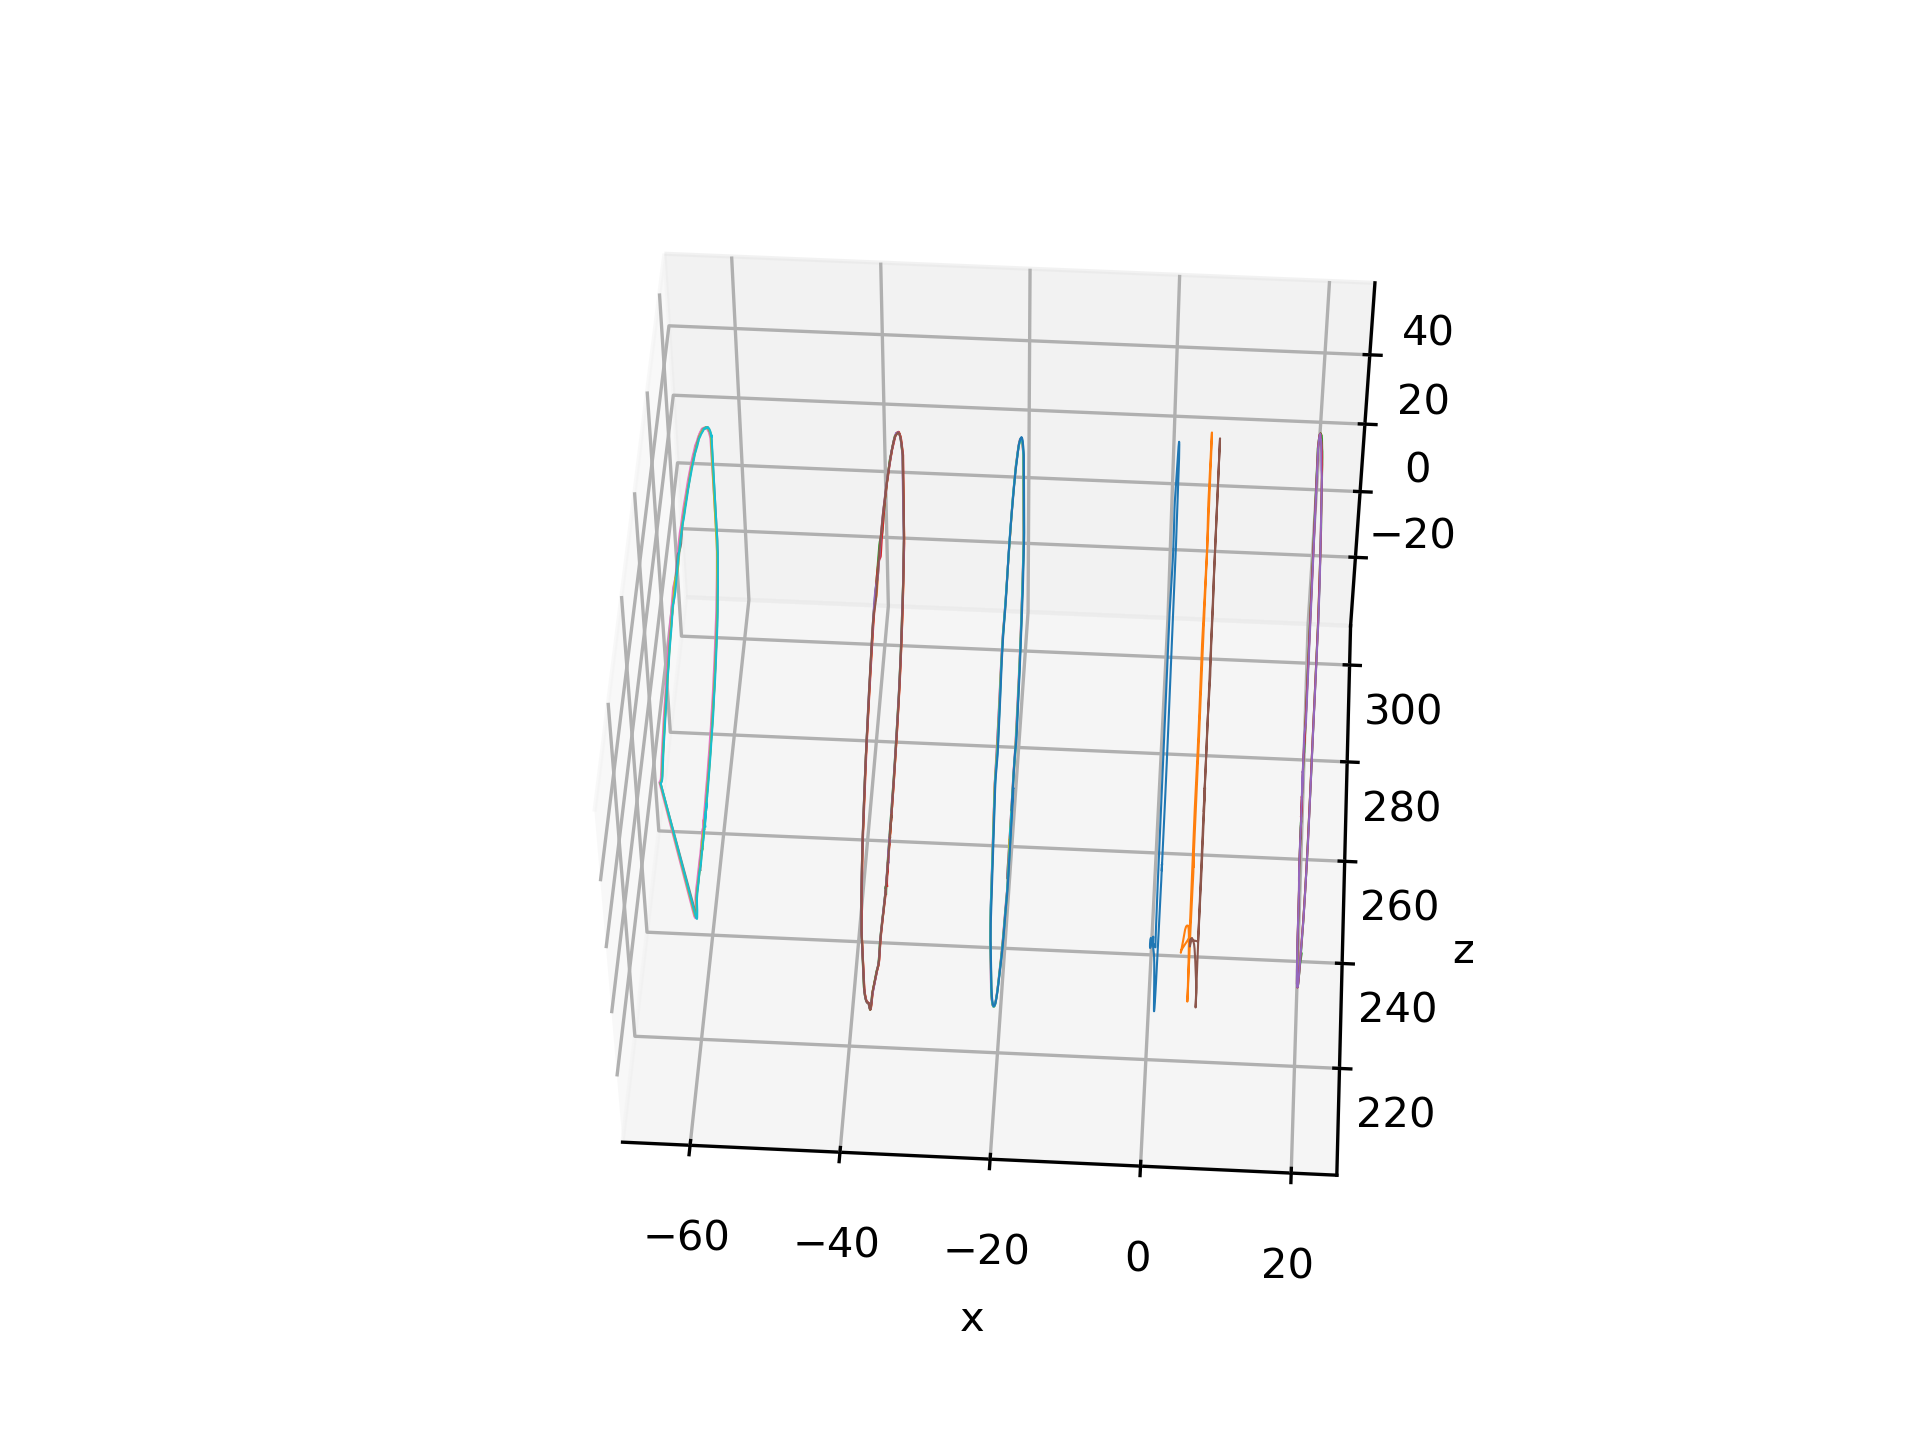

----- total of 20 cases plotted for x_right -----


In [81]:
%matplotlib notebook
session_count = 0
err_tracks = [] # keeps all track names that has error too large

for session in x_keys:
    session_data = data[session]
    track_count = 0
        
    plt.figure()
    ax = plt.axes(projection='3d')
    for track_case in session_data:

        temp = session_data[track_case]
        num_id = check_track_num(temp)
        if (num_id>=5):
            print("number of tracks: ",num_id)
            print("track case is: ",track_case)
        else:
            temp_normalized, weight = normalize(temp, "x")
            ax.plot3D(temp_normalized['x_cm'], \
                      temp_normalized['z_cm'] ,\
                      temp_normalized['y_cm'], linewidth=0.5)
            track_count += 1
    session_count+=1
    print("----- total of", str(track_count), "cases plotted for", session,  "-----")
    plt.xlabel("x")
    plt.ylabel("z")
#     plt.xlim(-22,-18)

